In [1]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.7.0+cu126
CUDA version: 12.6


In [5]:
import os
from pathlib import Path
import re

def find_vtk_files_summary(base_path):
    """Find VTK files and provide a compact summary."""
    base_path = Path(base_path)
    
    print(f"Searching for VTK/VTU files in: {base_path}")
    print(f"{'='*80}\n")
    
    vtk_files = list(base_path.rglob('*.vtu')) + list(base_path.rglob('*.vtk'))
    
    if not vtk_files:
        print("No VTK/VTU files found!")
        return
    
    print(f"Found {len(vtk_files)} VTK/VTU files\n")
    
    # Group by directory depth
    depth_groups = {}
    for vtk_file in vtk_files:
        rel_path = vtk_file.relative_to(base_path)
        depth = len(rel_path.parts) - 1
        
        if depth not in depth_groups:
            depth_groups[depth] = []
        depth_groups[depth].append(rel_path)
    
    print("VTK FILES BY DIRECTORY DEPTH:")
    for depth in sorted(depth_groups.keys()):
        files = depth_groups[depth]
        print(f"\n  Depth {depth} ({len(files)} files):")
        if len(files) > 0:
            sample_path = files[0]
            print(f"    Pattern: {'/'.join(sample_path.parts[:-1])}/...")
            print(f"    Example: {sample_path}")
    
    # Pattern analysis
    print(f"\n{'='*80}")
    print("PATTERN ANALYSIS:")
    
    # Reynolds numbers
    reynolds_patterns = {}
    for vtk_file in vtk_files:
        path_str = str(vtk_file)
        reynolds_match = re.search(r'[Rr]eynolds[_\s]*(\d+)', path_str)
        if reynolds_match:
            re_num = int(reynolds_match.group(1))
            if re_num not in reynolds_patterns:
                reynolds_patterns[re_num] = []
            reynolds_patterns[re_num].append(vtk_file)
    
    if reynolds_patterns:
        print(f"\n  Reynolds numbers: {sorted(reynolds_patterns.keys())}")
        for re_num in sorted(reynolds_patterns.keys())[:3]:
            print(f"    Re={re_num}: {len(reynolds_patterns[re_num])} files")
        if len(reynolds_patterns) > 3:
            print(f"    ... and {len(reynolds_patterns) - 3} more Reynolds numbers")
    
    # Timestep patterns
    timestep_dirs = set()
    for vtk_file in vtk_files:
        path_str = str(vtk_file.parent)
        timestep_match = re.search(r'/(\d+)$', path_str)
        if timestep_match:
            timestep_dirs.add(timestep_match.group(1))
    
    if timestep_dirs:
        sorted_timesteps = sorted([int(t) for t in timestep_dirs])
        print(f"\n  Timestep directories: {len(sorted_timesteps)} unique")
        print(f"    Range: {min(sorted_timesteps)} to {max(sorted_timesteps)}")
        print(f"    Samples: {sorted_timesteps[:5]}{'...' if len(sorted_timesteps) > 5 else ''}")
    
    # File naming patterns
    print(f"\n  File naming patterns:")
    filenames = set(f.name for f in vtk_files)
    print(f"    Unique filenames: {len(filenames)}")
    for name in sorted(filenames)[:5]:
        count = sum(1 for f in vtk_files if f.name == name)
        print(f"      '{name}': {count} occurrences")
    if len(filenames) > 5:
        print(f"      ... and {len(filenames) - 5} more unique names")
    
    return vtk_files


def compare_structures_compact(path1, path2):
    """Compact comparison of two directory structures."""
    print("COMPARING DIRECTORY STRUCTURES")
    print(f"{'='*80}\n")
    
    path1 = Path(path1)
    path2 = Path(path2)
    
    def get_structure_summary(path):
        """Get summary statistics for a path."""
        vtk_files = list(path.rglob('*.vtu')) + list(path.rglob('*.vtk'))
        
        reynolds_nums = set()
        timesteps = set()
        
        for vtk_file in vtk_files:
            path_str = str(vtk_file)
            re_match = re.search(r'[Rr]eynolds[_\s]*(\d+)', path_str)
            if re_match:
                reynolds_nums.add(int(re_match.group(1)))
            
            ts_match = re.search(r'/(\d+)/', path_str)
            if ts_match:
                timesteps.add(int(ts_match.group(1)))
        
        # Get directory depth of VTK files
        if vtk_files:
            depths = [len(f.relative_to(path).parts) for f in vtk_files]
            avg_depth = sum(depths) / len(depths)
        else:
            avg_depth = 0
        
        return {
            'total_dirs': sum(1 for _ in path.rglob('*') if _.is_dir()),
            'total_files': sum(1 for _ in path.rglob('*') if _.is_file()),
            'vtk_files': len(vtk_files),
            'reynolds_numbers': sorted(reynolds_nums),
            'timesteps': len(timesteps),
            'avg_vtk_depth': avg_depth
        }
    
    print("STRUCTURE 1 (OLD DATA):")
    print(f"  Path: {path1}")
    if path1.exists():
        summary1 = get_structure_summary(path1)
        print(f"  Total directories: {summary1['total_dirs']}")
        print(f"  Total files: {summary1['total_files']}")
        print(f"  VTK files: {summary1['vtk_files']}")
        print(f"  Reynolds numbers: {summary1['reynolds_numbers']}")
        print(f"  Timesteps: {summary1['timesteps']}")
        print(f"  Avg VTK depth: {summary1['avg_vtk_depth']:.1f}")
    else:
        print("  Path does not exist!")
    
    print(f"\n{'='*80}\n")
    
    print("STRUCTURE 2 (NEW DATA):")
    print(f"  Path: {path2}")
    if path2.exists():
        summary2 = get_structure_summary(path2)
        print(f"  Total directories: {summary2['total_dirs']}")
        print(f"  Total files: {summary2['total_files']}")
        print(f"  VTK files: {summary2['vtk_files']}")
        print(f"  Reynolds numbers: {summary2['reynolds_numbers']}")
        print(f"  Timesteps: {summary2['timesteps']}")
        print(f"  Avg VTK depth: {summary2['avg_vtk_depth']:.1f}")
    else:
        print("  Path does not exist!")


# =============================================================================
# RUN ANALYSIS
# =============================================================================

print("ANALYZING NEW DATA STRUCTURE")
print("="*80)
new_data_path = "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150"
find_vtk_files_summary(new_data_path)

print("\n\n")

print("COMPARING OLD VS NEW STRUCTURES")
print("="*80)
old_data_path = "/home/jtb3sud/Kármán vortex street"
compare_structures_compact(old_data_path, new_data_path)

ANALYZING NEW DATA STRUCTURE
Searching for VTK/VTU files in: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150

Found 2406 VTK/VTU files

VTK FILES BY DIRECTORY DEPTH:

  Depth 4 (2406 files):
    Pattern: Reynolds_50/Reynolds_50/VTK/Reynolds_50_4450/...
    Example: Reynolds_50/Reynolds_50/VTK/Reynolds_50_4450/internal.vtu

PATTERN ANALYSIS:

  Reynolds numbers: [1]
    Re=1: 2406 files

  File naming patterns:
    Unique filenames: 1
      'internal.vtu': 2406 occurrences



COMPARING OLD VS NEW STRUCTURES
COMPARING DIRECTORY STRUCTURES

STRUCTURE 1 (OLD DATA):
  Path: /home/jtb3sud/Kármán vortex street
  Total directories: 826
  Total files: 2920
  VTK files: 402
  Reynolds numbers: [20, 100]
  Timesteps: 0
  Avg VTK depth: 4.0


STRUCTURE 2 (NEW DATA):
  Path: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150
  Total directories: 12094
  Total files: 38815
  VTK files: 2406
  Reynolds numbers: [1]
  Timesteps: 0
  Avg VTK depth: 5.0


In [6]:
# Quick check - what Reynolds directories exist?
new_data_path = Path("/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150")
reynolds_dirs = [d.name for d in new_data_path.iterdir() if d.is_dir() and 'Reynolds' in d.name]
print(f"Reynolds directories found: {sorted(reynolds_dirs)[:10]}")
print(f"Total: {len(reynolds_dirs)}")

Reynolds directories found: ['Reynolds_1', 'Reynolds_100', 'Reynolds_150', 'Reynolds_20', 'Reynolds_40', 'Reynolds_50']
Total: 6


In [9]:
import re
from pathlib import Path

def inspect_directory_names(base_data_dir):
    """
    Directly reads and prints the numerical timestep values from directory names
    for each Reynolds case to show the raw data sequence.
    This version correctly handles floating-point numbers in directory names
    and looks for them in the correct nested directory structure.
    """
    base_data_dir = Path(base_data_dir)
    print(f"Directly inspecting timestep directory names in: {base_data_dir}")
    print("="*80)
    
    if not base_data_dir.exists():
        print(f"Directory {base_data_dir} does not exist!")
        return

    # Find all Reynolds_XX directories at the base level, sorted numerically
    try:
        reynolds_dirs = sorted(
            [d for d in base_data_dir.iterdir() if d.is_dir() and d.name.startswith('Reynolds_')],
            key=lambda x: int(re.search(r'Reynolds_(\d+)', x.name).group(1))
        )
    except (ValueError, AttributeError):
        print("Could not sort Reynolds directories numerically. Using alphabetical sort.")
        reynolds_dirs = sorted([d for d in base_data_dir.iterdir() if d.is_dir() and d.name.startswith('Reynolds_')])

    print(f"Found {len(reynolds_dirs)} Reynolds directories to inspect.")
    
    for re_dir in reynolds_dirs:
        re_match = re.search(r'Reynolds_(\d+)', re_dir.name)
        if not re_match:
            continue
        reynolds_num = int(re_match.group(1))
        
        print(f"\n--- Case: Re = {reynolds_num} ---")
        
        # Navigate to the double-nested Reynolds directory, as per the correct path structure.
        data_dir = re_dir / re_dir.name
        print(f"  Inspecting path: {data_dir}")

        if not data_dir.is_dir():
            print("  -> Nested Reynolds directory not found.")
            continue
            
        # Get all child directories directly from this path.
        timestep_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
        
        # Attempt to convert directory names to floating-point numbers
        time_values = []
        for ts_dir in timestep_dirs:
            # Use a regex that captures integers and decimals from the entire directory name
            match = re.search(r'^(\d+\.?\d*)$', ts_dir.name)
            if match:
                try:
                    time_values.append(float(match.group(1)))
                except ValueError:
                    print(f"  Could not convert '{match.group(1)}' to a float.")

        if not time_values:
            print("  -> Could not find any directories with a valid numerical name (e.g., '0.025').")
            continue

        # Sort the numbers to see the actual sequence
        time_values.sort()
        
        print(f"  Found {len(time_values)} numerical timestep directories.")
        print(f"  First 15 sorted timestep values: {time_values[:15]}")


# Test the inspection function
if __name__ == "__main__":
    NEW_DATA_DIR = "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~"
    inspect_directory_names(NEW_DATA_DIR)



Directly inspecting timestep directory names in: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~
Found 8 Reynolds directories to inspect.

--- Case: Re = 200 ---
  Inspecting path: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~/Reynolds_200/Reynolds_200
  Found 401 numerical timestep directories.
  First 15 sorted timestep values: [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35]

--- Case: Re = 250 ---
  Inspecting path: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~/Reynolds_250/Reynolds_250
  Found 401 numerical timestep directories.
  First 15 sorted timestep values: [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35]

--- Case: Re = 300 ---
  Inspecting path: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~/Reynolds_300/Reynolds_300
  Found 401 numerical timestep directories.
  First 15 sorted timestep values: [0.0, 0.025, 0.05, 0.075, 0.1, 0.1

In [2]:
import re
from pathlib import Path
from collections import Counter

def analyze_reynolds_cases(base_data_dir):
    """
    Analyzes Reynolds cases to determine simulation duration and write intervals.

    This function inspects the timestep directories to extract:
    - The total number of timesteps.
    - The start and end "time" values (from directory names).
    - The most common interval between saved timesteps.
    """
    base_data_dir = Path(base_data_dir)
    print(f"Analyzing Karman vortex cases in: {base_data_dir}")
    
    if not base_data_dir.exists():
        print(f"Directory {base_data_dir} does not exist!")
        return []

    analysis_results = []
    
    # Find all Reynolds_XX directories at the base level
    reynolds_dirs = sorted(
        [d for d in base_data_dir.iterdir() if d.is_dir() and d.name.startswith('Reynolds_')],
        key=lambda x: int(re.search(r'Reynolds_(\d+)', x.name).group(1))
    )
    
    print(f"Found {len(reynolds_dirs)} Reynolds directories to analyze.")
    
    for re_dir in reynolds_dirs:
        re_match = re.search(r'Reynolds_(\d+)', re_dir.name)
        if not re_match:
            continue
        reynolds_num = int(re_match.group(1))
        
        # Navigate to the VTK directory
        vtk_dir = re_dir / re_dir.name / "VTK"
        if not vtk_dir.is_dir():
            continue
            
        # Get all timestep directories
        timestep_dirs = [d for d in vtk_dir.iterdir() if d.is_dir()]
        
        # Extract numerical time values from directory names
        time_values = []
        for ts_dir in timestep_dirs:
            # Pattern: Reynolds_XX_timestep
            ts_match = re.search(rf'Reynolds_{reynolds_num}_(\d+)', ts_dir.name)
            if ts_match:
                time_values.append(int(ts_match.group(1)))
        
        if not time_values:
            print(f"  Re={reynolds_num}: No valid timestep directories found.")
            continue

        # Sort times to ensure correct order
        time_values.sort()
        
        # Calculate intervals between consecutive timesteps
        intervals = [time_values[i] - time_values[i-1] for i in range(1, len(time_values))]
        
        # Find the most common interval
        if intervals:
            most_common_interval = Counter(intervals).most_common(1)[0][0]
        else:
            most_common_interval = 0 # Case with only one timestep

        analysis_results.append({
            "reynolds_num": reynolds_num,
            "timesteps": len(time_values),
            "start_time": time_values[0],
            "end_time": time_values[-1],
            "write_interval": most_common_interval
        })

    return analysis_results

def print_analysis_summary(results):
    """Prints a formatted summary of the analysis results."""
    if not results:
        print("No results to display.")
        return
        
    print("\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)
    print(f"{'Re':<10} {'Timesteps':<12} {'Start Time':<15} {'End Time':<15} {'Write Interval':<15}")
    print(f"{'-'*8:<10} {'-'*10:<12} {'-'*13:<15} {'-'*13:<15} {'-'*14:<15}")
    
    for res in results:
        print(f"{res['reynolds_num']:<10} {res['timesteps']:<12} {res['start_time']:<15} {res['end_time']:<15} {res['write_interval']:<15}")


# Test the analysis function
if __name__ == "__main__":
    NEW_DATA_DIR = "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~"
    
    results = analyze_reynolds_cases(NEW_DATA_DIR)
    print_analysis_summary(results)


Analyzing Karman vortex cases in: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~
Found 8 Reynolds directories to analyze.
  Re=250: No valid timestep directories found.
  Re=350: No valid timestep directories found.

ANALYSIS SUMMARY
Re         Timesteps    Start Time      End Time        Write Interval 
--------   ----------   -------------   -------------   -------------- 
200        761          0               100000          25             
300        401          0               100000          250            
400        401          0               100000          250            
450        401          0               100000          250            
500        401          0               100000          250            
550        401          0               100000          250            


In [8]:
# Let's look at what's actually inside one Reynolds case
from pathlib import Path

new_data_path = Path("/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150")

# Pick one Reynolds number to explore
re_dir = new_data_path / "Reynolds_50"

print("Exploring Reynolds_50 structure:")
print("="*80)

# Level 1: What's directly in Reynolds_50?
print("\n1. Contents of Reynolds_50/:")
for item in sorted(re_dir.iterdir())[:10]:
    print(f"   {item.name}/ " if item.is_dir() else f"   {item.name}")

# Level 2: What's in the nested Reynolds_50?
inner_dir = re_dir / "Reynolds_50"
if inner_dir.exists():
    print("\n2. Contents of Reynolds_50/Reynolds_50/:")
    for item in sorted(inner_dir.iterdir())[:10]:
        print(f"   {item.name}/ " if item.is_dir() else f"   {item.name}")

# Level 3: What's in VTK?
vtk_dir = inner_dir / "VTK"
if vtk_dir.exists():
    print("\n3. Contents of Reynolds_50/Reynolds_50/VTK/ (first 10 items):")
    items = sorted(vtk_dir.iterdir())[:10]
    for item in items:
        print(f"   {item.name}/ " if item.is_dir() else f"   {item.name}")
    print(f"   ... (total: {len(list(vtk_dir.iterdir()))} items)")

# Level 4: What's in a timestep directory?
if vtk_dir.exists():
    timestep_dirs = [d for d in vtk_dir.iterdir() if d.is_dir()]
    if timestep_dirs:
        sample_ts = sorted(timestep_dirs)[0]
        print(f"\n4. Contents of {sample_ts.name}/:")
        for item in sorted(sample_ts.iterdir()):
            if item.is_file():
                size = item.stat().st_size / (1024*1024)  # MB
                print(f"   {item.name} ({size:.2f} MB)")
            else:
                print(f"   {item.name}/")

Exploring Reynolds_50 structure:

1. Contents of Reynolds_50/:
   Reynolds_50/ 

2. Contents of Reynolds_50/Reynolds_50/:
   0/ 
   0.025/ 
   0.05/ 
   0.075/ 
   0.1/ 
   0.125/ 
   0.15/ 
   0.175/ 
   0.2/ 
   0.225/ 

3. Contents of Reynolds_50/Reynolds_50/VTK/ (first 10 items):
   Reynolds_50.vtm.series
   Reynolds_50_0/ 
   Reynolds_50_0.vtm
   Reynolds_50_100/ 
   Reynolds_50_100.vtm
   Reynolds_50_1000/ 
   Reynolds_50_1000.vtm
   Reynolds_50_10000/ 
   Reynolds_50_10000.vtm
   Reynolds_50_1025/ 
   ... (total: 803 items)

4. Contents of Reynolds_50_0/:
   boundary/
   boundary.vtm (0.00 MB)
   internal.vtu (5.78 MB)


In [9]:
import vtk

# Test reading one file
test_file = "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/Reynolds_50/Reynolds_50/VTK/Reynolds_50_0/internal.vtu"

reader = vtk.vtkXMLUnstructuredGridReader()
reader.SetFileName(test_file)
reader.Update()
mesh = reader.GetOutput()

print(f"Number of points: {mesh.GetNumberOfPoints()}")
print(f"Number of cells: {mesh.GetNumberOfCells()}")

print("\nAvailable fields:")
point_data = mesh.GetPointData()
for i in range(point_data.GetNumberOfArrays()):
    array = point_data.GetArray(i)
    print(f"  - {array.GetName()} (components: {array.GetNumberOfComponents()})")

Number of points: 60746
Number of cells: 29938

Available fields:
  - p (components: 1)
  - U (components: 3)
  - vorticity (components: 3)


In [ ]:
import torch
import numpy as np
from pathlib import Path
import os

def ultra_fast_static_graph_analysis(data_dir):
    """
    Ultra-fast analysis for STATIC GRAPHS.
    Since mesh doesn't change, we only need 1 sample per Reynolds number.
    """
    
    data_path = Path(data_dir)
    
    print("="*80)
    print("ULTRA-FAST STATIC GRAPH ANALYSIS")
    print("(Only sampling 1 timestep per Reynolds case)")
    print("="*80)
    
    # Part 1: Individual cases - just look at first sample of each
    print("\n1. INDIVIDUAL REYNOLDS CASES - GRAPH SIZE")
    print("-" * 80)
    
    individual_dirs = [
        data_path / "individual_cases",
        data_path / "normalized" / "individual_cases_normalized"
    ]
    
    reynolds_info = {}
    
    for ind_dir in individual_dirs:
        if not ind_dir.exists():
            continue
        
        case_files = sorted(ind_dir.glob("*.pt"))
        print(f"\nAnalyzing {ind_dir.name}: {len(case_files)} files")
        print(f"{'Reynolds':<12} {'Nodes':<10} {'Edges':<10} {'Timesteps':<12} {'Size (MB)':<12} {'MB/timestep':<12}")
        print("-" * 80)
        
        for case_file in case_files:
            # Extract Reynolds number
            parts = case_file.stem.split('_')
            reynolds = None
            for i, part in enumerate(parts):
                if part == 'Reynolds' and i+1 < len(parts):
                    reynolds_str = parts[i+1].replace('dir0', '').replace('dir1', '')
                    try:
                        reynolds = int(reynolds_str)
                    except:
                        pass
                    break
            
            if reynolds is None:
                continue
            
            # Get file size
            size_mb = case_file.stat().st_size / (1024**2)
            
            # Load ONLY first sample to get graph structure
            try:
                dataset = torch.load(case_file, weights_only=False)
                n_timesteps = len(dataset)
                
                if n_timesteps > 0:
                    first_sample = dataset[0]
                    n_nodes = first_sample.x.shape[0]
                    n_edges = first_sample.edge_index.shape[1]
                    
                    mb_per_timestep = size_mb / n_timesteps
                    
                    # Store info
                    if reynolds not in reynolds_info or 'normalized' not in str(case_file):
                        reynolds_info[reynolds] = {
                            'nodes': n_nodes,
                            'edges': n_edges,
                            'timesteps': n_timesteps,
                            'size_mb': size_mb,
                            'mb_per_timestep': mb_per_timestep,
                            'file': case_file.name
                        }
                    
                    print(f"{reynolds:<12} {n_nodes:<10} {n_edges:<10} {n_timesteps:<12} {size_mb:<12.1f} {mb_per_timestep:<12.3f}")
                    
                    # Free memory immediately
                    del dataset, first_sample
                    
            except Exception as e:
                print(f"Error loading {case_file.name}: {e}")
    
    # Part 2: Analyze split files - sample first few
    print("\n\n2. SPLIT FILES - SAMPLING STRUCTURE")
    print("-" * 80)
    
    split_files = ['train', 'val', 'test']
    split_info = {}
    
    for split in split_files:
        filename = f"karman_vortex_{split}_with_pos.pt"
        filepath = data_path / filename
        
        if not filepath.exists():
            continue
        
        print(f"\n{split.upper()}:")
        
        try:
            # Load file
            dataset = torch.load(filepath, weights_only=False)
            n_total = len(dataset)
            file_size_gb = filepath.stat().st_size / (1024**3)
            
            # Sample first 10 to identify unique Reynolds numbers
            sample_size = min(10, n_total)
            reynolds_in_split = set()
            nodes_by_reynolds = {}
            
            for i in range(sample_size):
                sample = dataset[i]
                
                # Get Reynolds number
                re = None
                if hasattr(sample, 'global_params') and sample.global_params is not None:
                    re = int(sample.global_params[0].item())
                elif hasattr(sample, 'reynolds_number'):
                    re = int(sample.reynolds_number)
                
                if re is not None:
                    reynolds_in_split.add(re)
                    if re not in nodes_by_reynolds:
                        nodes_by_reynolds[re] = sample.x.shape[0]
            
            # Estimate based on known Reynolds info
            estimated_samples_per_re = {}
            if reynolds_info:
                for re in reynolds_in_split:
                    if re in reynolds_info:
                        # File size / (samples * graph_size) to estimate samples per Re
                        estimated_samples_per_re[re] = reynolds_info[re]['timesteps']
            
            split_info[split] = {
                'total_samples': n_total,
                'file_size_gb': file_size_gb,
                'reynolds_numbers': sorted(reynolds_in_split),
                'n_reynolds': len(reynolds_in_split),
                'mb_per_sample': (file_size_gb * 1024) / n_total
            }
            
            print(f"  Total samples: {n_total}")
            print(f"  File size: {file_size_gb:.2f} GB")
            print(f"  MB per sample: {split_info[split]['mb_per_sample']:.3f}")
            print(f"  Unique Reynolds #s: {len(reynolds_in_split)}")
            print(f"  Reynolds numbers: {sorted(reynolds_in_split)}")
            
            # Free memory
            del dataset
            
        except Exception as e:
            print(f"  Error: {e}")
    
    # Part 3: Analysis - why files differ
    print("\n\n3. WHY FILE SIZES DIFFER - ROOT CAUSE ANALYSIS")
    print("="*80)
    
    if reynolds_info:
        # Sort by various metrics
        by_nodes = sorted(reynolds_info.items(), key=lambda x: x[1]['nodes'], reverse=True)
        by_timesteps = sorted(reynolds_info.items(), key=lambda x: x[1]['timesteps'], reverse=True)
        by_size = sorted(reynolds_info.items(), key=lambda x: x[1]['size_mb'], reverse=True)
        
        # Factor 1: Graph size (nodes)
        print("\nFACTOR 1: GRAPH SIZE (Number of Nodes)")
        print("-" * 80)
        print(f"{'Reynolds':<12} {'Nodes':<10} {'Ratio to Min':<12}")
        print("-" * 80)
        min_nodes = min(info['nodes'] for info in reynolds_info.values())
        for re, info in by_nodes[:10]:
            ratio = info['nodes'] / min_nodes
            print(f"{re:<12} {info['nodes']:<10} {ratio:<12.2f}x")
        
        nodes_list = [info['nodes'] for info in reynolds_info.values()]
        print(f"\nNodes range: {min(nodes_list)} - {max(nodes_list)}")
        print(f"Ratio (max/min): {max(nodes_list) / min(nodes_list):.2f}x")
        
        # Factor 2: Number of timesteps
        print("\n\nFACTOR 2: NUMBER OF TIMESTEPS")
        print("-" * 80)
        print(f"{'Reynolds':<12} {'Timesteps':<12} {'Ratio to Min':<12}")
        print("-" * 80)
        min_timesteps = min(info['timesteps'] for info in reynolds_info.values())
        for re, info in by_timesteps[:10]:
            ratio = info['timesteps'] / min_timesteps
            print(f"{re:<12} {info['timesteps']:<12} {ratio:<12.2f}x")
        
        timesteps_list = [info['timesteps'] for info in reynolds_info.values()]
        print(f"\nTimesteps range: {min(timesteps_list)} - {max(timesteps_list)}")
        print(f"Ratio (max/min): {max(timesteps_list) / min(timesteps_list):.2f}x")
        
        # Combined effect
        print("\n\nCOMBINED EFFECT: LARGEST FILES")
        print("-" * 80)
        print(f"{'Reynolds':<12} {'Size (MB)':<12} {'Nodes':<10} {'Timesteps':<12} {'Explanation'}")
        print("-" * 80)
        for re, info in by_size[:10]:
            explanation = []
            if info['nodes'] > np.median(nodes_list):
                explanation.append("Large mesh")
            if info['timesteps'] > np.median(timesteps_list):
                explanation.append("Many timesteps")
            exp_str = ", ".join(explanation) if explanation else "Small mesh + few timesteps"
            print(f"{re:<12} {info['size_mb']:<12.1f} {info['nodes']:<10} {info['timesteps']:<12} {exp_str}")
        
        # Correlations
        print("\n\nCORRELATIONS WITH FILE SIZE:")
        print("-" * 80)
        
        reynolds_nums = list(reynolds_info.keys())
        sizes = [info['size_mb'] for info in reynolds_info.values()]
        nodes = [info['nodes'] for info in reynolds_info.values()]
        timesteps = [info['timesteps'] for info in reynolds_info.values()]
        
        if len(reynolds_nums) > 2:
            corr_re = np.corrcoef(reynolds_nums, sizes)[0, 1]
            corr_nodes = np.corrcoef(nodes, sizes)[0, 1]
            corr_timesteps = np.corrcoef(timesteps, sizes)[0, 1]
            
            print(f"Reynolds number:  {corr_re:>6.3f} ", end="")
            print("→ Higher Re = larger files" if corr_re > 0.5 else "→ Weak relationship")
            
            print(f"Number of nodes:  {corr_nodes:>6.3f} ", end="")
            print("→ STRONG: More nodes = larger files" if corr_nodes > 0.7 else "→ Moderate effect")
            
            print(f"Number of timesteps: {corr_timesteps:>6.3f} ", end="")
            print("→ STRONG: More timesteps = larger files" if corr_timesteps > 0.7 else "→ Moderate effect")
    
    # Part 4: Split comparison
    if split_info:
        print("\n\n4. TRAIN/VAL/TEST SPLIT COMPARISON")
        print("="*80)
        
        for split in ['train', 'val', 'test']:
            if split in split_info:
                info = split_info[split]
                print(f"\n{split.upper()}:")
                print(f"  Samples: {info['total_samples']}")
                print(f"  Size: {info['file_size_gb']:.2f} GB")
                print(f"  Reynolds cases: {info['n_reynolds']}")
                print(f"  Samples per Reynolds: {info['total_samples'] / info['n_reynolds']:.1f}")
                print(f"  Reynolds numbers: {info['reynolds_numbers']}")
        
        # Why splits differ
        if 'train' in split_info and 'val' in split_info:
            print(f"\nWHY TRAIN IS LARGER THAN VAL:")
            train_samples = split_info['train']['total_samples']
            val_samples = split_info['val']['total_samples']
            ratio = train_samples / val_samples
            print(f"  Sample ratio (train/val): {ratio:.2f}x")
            print(f"  Train has {split_info['train']['n_reynolds']} Reynolds cases")
            print(f"  Val has {split_info['val']['n_reynolds']} Reynolds cases")
            
            if reynolds_info:
                train_re = split_info['train']['reynolds_numbers']
                val_re = split_info['val']['reynolds_numbers']
                
                train_avg_nodes = np.mean([reynolds_info[re]['nodes'] for re in train_re if re in reynolds_info])
                val_avg_nodes = np.mean([reynolds_info[re]['nodes'] for re in val_re if re in reynolds_info])
                
                print(f"  Avg nodes in train cases: {train_avg_nodes:.0f}")
                print(f"  Avg nodes in val cases: {val_avg_nodes:.0f}")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80)
    
    return reynolds_info, split_info


if __name__ == "__main__":
    DATA_DIR = "/standard/sds_baek_energetic/von_karman_vortex/full_data"
    
    print("Enter the path to your processed data directory:")
    print(f"(Press Enter to use: {DATA_DIR})")
    
    user_input = input().strip()
    if user_input:
        DATA_DIR = user_input
    
    if not os.path.exists(DATA_DIR):
        print(f"\nERROR: Directory not found: {DATA_DIR}")
    else:
        ultra_fast_static_graph_analysis(DATA_DIR)

Enter the path to your processed data directory:
(Press Enter to use: /standard/sds_baek_energetic/von_karman_vortex/full_data)


ULTRA-FAST STATIC GRAPH ANALYSIS
(Only sampling 1 timestep per Reynolds case)

1. INDIVIDUAL REYNOLDS CASES - GRAPH SIZE
--------------------------------------------------------------------------------

Analyzing individual_cases: 23 files
Reynolds     Nodes      Edges      Timesteps    Size (MB)    MB/timestep 
--------------------------------------------------------------------------------
1000         165082     865226     400          5051.5       12.629      
100          60746      318178     400          1859.0       4.648       
150          60746      318178     400          1859.0       4.648       
1            60746      318178     400          1859.0       4.648       
200          120696     623052     400          3693.2       9.233       
20           60746      318178     400          1859.0       4.648       
250          120696     623052     400          3693.2       9.233       
300          160556     823104     400          4912.7       12.282      
350          

In [ ]:
import vtk
import numpy as np
import torch
from torch_geometric.data import Data
from pathlib import Path
import re
import json
from datetime import datetime
from sklearn.model_selection import train_test_split

class KarmanVortexProcessorNewStructure:
    """
    Processor for Karman vortex street simulations - NEW DATA STRUCTURE.
    Modified to handle MULTIPLE base directories.
    """
    
    def __init__(self, base_data_dirs, include_parameters_as_features=True):
        """
        Args:
            base_data_dirs: List of base directory paths or single path
            include_parameters_as_features: Whether to include Reynolds number as global feature
        """
        # Convert single path to list for uniform handling
        if isinstance(base_data_dirs, (str, Path)):
            base_data_dirs = [base_data_dirs]
        
        self.base_data_dirs = [Path(d) for d in base_data_dirs]
        self.include_parameters_as_features = include_parameters_as_features
        
        # Position variables (will be first in x tensor)
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        
        # Physical variable names from VTK files - RAW DATA ONLY
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        
        # All variables in x tensor (positions + physics)
        self.var_names = self.position_vars + self.physics_vars
        
        # Global parameters
        self.parameter_names = ['reynolds_number']
        
        # For tracking processed cases
        self.case_info = {}
        self.all_variable_stats = {}
        self.parameter_stats = {}
        
    def discover_reynolds_cases(self):
        """Discover all available Reynolds number cases from ALL base directories."""
        print(f"Discovering Karman vortex cases from {len(self.base_data_dirs)} directories:")
        for dir_path in self.base_data_dirs:
            print(f"  - {dir_path}")
        
        all_case_dirs = []
        
        # Process each base directory
        for base_dir_idx, base_data_dir in enumerate(self.base_data_dirs):
            print(f"\nProcessing directory {base_dir_idx + 1}/{len(self.base_data_dirs)}: {base_data_dir}")
            
            if not base_data_dir.exists():
                print(f"  WARNING: Directory {base_data_dir} does not exist! Skipping.")
                continue
            
            # Find all Reynolds_XX directories at the base level
            reynolds_dirs = sorted([d for d in base_data_dir.iterdir() 
                                   if d.is_dir() and d.name.startswith('Reynolds_')])
            
            print(f"  Found {len(reynolds_dirs)} Reynolds directories")
            
            for re_dir in reynolds_dirs:
                # Extract Reynolds number from directory name
                re_match = re.search(r'Reynolds_(\d+)', re_dir.name)
                if not re_match:
                    print(f"    {re_dir.name}: Could not extract Reynolds number")
                    continue
                    
                reynolds_num = int(re_match.group(1))
                
                # NEW STRUCTURE: Look for double-nested Reynolds directory
                inner_re_dir = re_dir / re_dir.name
                
                if not inner_re_dir.exists():
                    print(f"    {re_dir.name}: No double-nested directory found")
                    continue
                
                # Look for VTK directory
                vtk_dir = inner_re_dir / "VTK"
                
                if not vtk_dir.exists():
                    print(f"    {re_dir.name}: No VTK directory found")
                    continue
                
                # Look for timestep directories
                timestep_dirs = [d for d in vtk_dir.iterdir() if d.is_dir()]
                
                if not timestep_dirs:
                    print(f"    {re_dir.name}: No timestep directories in VTK")
                    continue
                
                # Check for internal.vtu files in timestep directories
                valid_timesteps = []
                for ts_dir in timestep_dirs:
                    internal_file = ts_dir / "internal.vtu"
                    if internal_file.exists():
                        # Extract timestep number from directory name
                        ts_match = re.search(rf'Reynolds_{reynolds_num}_(\d+)', ts_dir.name)
                        if ts_match:
                            timestep = int(ts_match.group(1))
                            valid_timesteps.append((timestep, ts_dir))
                        else:
                            # Try to extract just a number if the pattern doesn't match
                            ts_match = re.search(r'(\d+)$', ts_dir.name)
                            if ts_match:
                                timestep = int(ts_match.group(1))
                                valid_timesteps.append((timestep, ts_dir))
                
                if valid_timesteps:
                    valid_timesteps.sort()  # Sort by timestep
                    # Include source directory index in case name to avoid conflicts
                    case_name = f"Reynolds_{reynolds_num}_dir{base_dir_idx}"
                    all_case_dirs.append((vtk_dir, case_name, reynolds_num, valid_timesteps, base_dir_idx))
                    print(f"    {re_dir.name}: {len(valid_timesteps)} timesteps (labeled as {case_name})")
                else:
                    print(f"    {re_dir.name}: No valid internal.vtu files found")
        
        if not all_case_dirs:
            print("\nNo valid Reynolds cases found across all directories!")
        else:
            print(f"\nTotal valid Reynolds cases across all directories: {len(all_case_dirs)}")
            
            # Summary by directory
            for dir_idx, base_dir in enumerate(self.base_data_dirs):
                dir_cases = [c for c in all_case_dirs if c[4] == dir_idx]
                print(f"  Directory {dir_idx + 1} ({base_dir.name}): {len(dir_cases)} cases")
            
        return all_case_dirs
    
    def read_vtu_data(self, filename):
        """Read VTU file and extract mesh data and fields."""
        reader = vtk.vtkXMLUnstructuredGridReader()
        reader.SetFileName(str(filename))
        reader.Update()
        mesh = reader.GetOutput()
        
        # Extract positions
        points = mesh.GetPoints()
        pos = np.array([points.GetPoint(i) for i in range(points.GetNumberOfPoints())])
        
        # Extract point data (physics fields)
        point_data = mesh.GetPointData()
        fields = {}
        
        for i in range(point_data.GetNumberOfArrays()):
            array = point_data.GetArray(i)
            name = array.GetName()
            n_components = array.GetNumberOfComponents()
            
            if name == 'p':  # Pressure field
                data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                fields['pressure'] = data
            elif name == 'U':  # Velocity vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                fields['velocity_x'] = data[:, 0]
                fields['velocity_y'] = data[:, 1] 
                fields['velocity_z'] = data[:, 2]
            elif name == 'vorticity':  # Vorticity vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                fields['vorticity_x'] = data[:, 0]
                fields['vorticity_y'] = data[:, 1]
                fields['vorticity_z'] = data[:, 2]
            elif n_components == 1:
                # Generic scalar field
                data = np.array([array.GetValue(j) for j in range(array.GetNumberOfTuples())])
                fields[name] = data
            else:
                # Generic vector field
                data = np.array([array.GetTuple(j) for j in range(array.GetNumberOfTuples())])
                for comp in range(n_components):
                    fields[f"{name}_{comp}"] = data[:, comp]
        
        return pos, fields, mesh
    
    def extract_mesh_connectivity(self, mesh):
        """Extract mesh connectivity for graph structure."""
        edge_set = set()
        n_cells = mesh.GetNumberOfCells()
        
        for i in range(n_cells):
            cell = mesh.GetCell(i)
            cell_type = cell.GetCellType()
            n_points = cell.GetNumberOfPoints()
            
            point_ids = [cell.GetPointId(j) for j in range(n_points)]
            edges = self._get_cell_edges(cell_type, point_ids)
            
            for edge in edges:
                edge_set.add(tuple(sorted(edge)))
        
        # Convert to directed edges
        directed_edges = []
        for edge in edge_set:
            directed_edges.append([edge[0], edge[1]])
            directed_edges.append([edge[1], edge[0]])
        
        return np.array(directed_edges).T if directed_edges else np.array([[], []])
    
    def _get_cell_edges(self, cell_type, point_ids):
        """Get edges for different VTK cell types."""
        edges = []
        
        if cell_type == 12:  # Hexahedron
            edges = [
                # Bottom face
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], 
                [point_ids[2], point_ids[3]], [point_ids[3], point_ids[0]],
                # Top face  
                [point_ids[4], point_ids[5]], [point_ids[5], point_ids[6]], 
                [point_ids[6], point_ids[7]], [point_ids[7], point_ids[4]],
                # Vertical edges
                [point_ids[0], point_ids[4]], [point_ids[1], point_ids[5]], 
                [point_ids[2], point_ids[6]], [point_ids[3], point_ids[7]]
            ]
        elif cell_type == 13:  # Wedge
            edges = [
                [point_ids[0], point_ids[1]], [point_ids[1], point_ids[2]], [point_ids[2], point_ids[0]],
                [point_ids[3], point_ids[4]], [point_ids[4], point_ids[5]], [point_ids[5], point_ids[3]],
                [point_ids[0], point_ids[3]], [point_ids[1], point_ids[4]], [point_ids[2], point_ids[5]]
            ]
        else:  # Other types - connect all pairs (simplified)
            for i in range(len(point_ids)):
                for j in range(i + 1, len(point_ids)):
                    edges.append([point_ids[i], point_ids[j]])
        
        return edges
    
    def create_global_parameters(self, reynolds_number):
        """Create global parameter tensor for the graph."""
        if not self.include_parameters_as_features:
            return None
        
        global_params = torch.tensor([float(reynolds_number)], dtype=torch.float)
        return global_params
    
    def analyze_variable_ranges_single_case(self, case_dir, case_name, reynolds_number, timesteps):
        """Analyze variable ranges for a single Reynolds case."""
        print(f"  Analyzing variable ranges for {case_name}...")
        
        case_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                           'all_values': []} for var in self.var_names}
        
        valid_files_count = 0
        
        for timestep, ts_dir in timesteps[:10]:  # Sample first 10 timesteps for efficiency
            internal_file = ts_dir / "internal.vtu"
            try:
                pos, fields, mesh = self.read_vtu_data(internal_file)
                
                valid_files_count += 1
                
                # Analyze positions
                for i, pos_var in enumerate(self.position_vars):
                    data = pos[:, i]
                    valid_data = data[np.isfinite(data)]
                    if len(valid_data) > 0:
                        case_stats[pos_var]['min'] = min(case_stats[pos_var]['min'], valid_data.min())
                        case_stats[pos_var]['max'] = max(case_stats[pos_var]['max'], valid_data.max())
                        case_stats[pos_var]['all_values'].extend(valid_data.flatten())
                
                # Analyze physics variables
                for var in self.physics_vars:
                    if var in fields:
                        data = fields[var]
                        valid_data = data[np.isfinite(data)]
                        if len(valid_data) > 0:
                            case_stats[var]['min'] = min(case_stats[var]['min'], valid_data.min())
                            case_stats[var]['max'] = max(case_stats[var]['max'], valid_data.max())
                            case_stats[var]['all_values'].extend(valid_data.flatten())
                
            except Exception as e:
                continue  # Skip problematic files silently
        
        if valid_files_count == 0:
            print(f"    Warning: No valid files could be read for case {case_name}")
            return None
        
        # Compute additional statistics
        final_stats = {}
        for var in self.var_names:
            if case_stats[var]['all_values'] and case_stats[var]['min'] != float('inf'):
                values = np.array(case_stats[var]['all_values'])
                final_stats[var] = {
                    'min': float(case_stats[var]['min']),
                    'max': float(case_stats[var]['max']),
                    'mean': float(values.mean()),
                    'std': float(values.std()),
                    'median': float(np.median(values)),
                    'q25': float(np.percentile(values, 25)),
                    'q75': float(np.percentile(values, 75))
                }
        
        return final_stats if final_stats else None
    
    def process_single_case(self, case_dir, case_name, reynolds_number, timesteps, output_path, source_dir_idx):
        """Process a single Reynolds case into PyG format - SHOCK TUBE FORMAT."""
        print(f"Processing case: {case_name}")
        print(f"  Reynolds number: {reynolds_number}")
        print(f"  Source directory: {self.base_data_dirs[source_dir_idx]}")
        print(f"  Timesteps: {len(timesteps)}")
        
        if len(timesteps) < 2:
            print(f"  Case {case_name} has insufficient timesteps ({len(timesteps)}). Skipping.")
            return None
        
        # Store parameter statistics
        self.parameter_stats[case_name] = {
            'reynolds_number': reynolds_number,
            'source_directory_index': source_dir_idx,
            'source_directory': str(self.base_data_dirs[source_dir_idx])
        }
        
        # Analyze variable ranges for this case
        case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name, reynolds_number, timesteps)
        
        pyg_data_list = []
        
        # Read first timestep to get mesh structure (static across timesteps)
        first_timestep, first_ts_dir = timesteps[0]
        first_internal = first_ts_dir / "internal.vtu"
        pos, _, mesh = self.read_vtu_data(first_internal)
        
        # Extract connectivity (static)
        edge_index = self.extract_mesh_connectivity(mesh)
        edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
        
        # Create global parameter features
        global_params = self.create_global_parameters(reynolds_number)
        
        # Process consecutive timestep pairs
        valid_pairs = 0
        total_pairs = len(timesteps) - 1
        
        for i in range(total_pairs):
            if i % 50 == 0:
                print(f"    Processing timestep pairs: {i}/{total_pairs}")
                
            current_timestep, current_ts_dir = timesteps[i]
            next_timestep, next_ts_dir = timesteps[i + 1]
            
            try:
                # Read current and next timestep data
                current_file = current_ts_dir / "internal.vtu"
                next_file = next_ts_dir / "internal.vtu"
                
                current_pos, current_fields, _ = self.read_vtu_data(current_file)
                next_pos, next_fields, _ = self.read_vtu_data(next_file)
                
                # Create feature arrays - COMBINE POSITIONS + PHYSICS (like shock tube)
                available_vars = [var for var in self.physics_vars if var in current_fields]
                
                # Build current features: [positions | physics]
                current_features_list = [current_pos]  # Start with positions
                for var in available_vars:
                    current_features_list.append(current_fields[var].reshape(-1, 1))
                current_features = np.hstack(current_features_list)
                
                # Build next features (targets are physics only, like shock tube)
                next_features = np.stack([next_fields[var] for var in available_vars], axis=-1)
                
                # Create PyG tensors
                x = torch.tensor(current_features, dtype=torch.float)  # [N, 3 positions + 7 physics]
                y = torch.tensor(next_features, dtype=torch.float)     # [N, 7 physics only]
                
                # Also store positions separately (for compatibility)
                pos_tensor = torch.tensor(current_pos, dtype=torch.float)
                
                # Create PyG Data object
                data_object = Data(
                    x=x,                              # Combined: positions + physics features
                    pos=pos_tensor,                   # Also store positions separately
                    edge_index=edge_index_tensor,     # Static connectivity
                    y=y,                             # Target (next timestep physics only)
                    
                    # Global parameters
                    global_params=global_params if self.include_parameters_as_features else None,
                    
                    # Metadata
                    case_name=case_name,
                    reynolds_number=reynolds_number,
                    source_directory_index=source_dir_idx,
                    timestep_current=current_timestep,
                    timestep_next=next_timestep,
                    feature_names=available_vars
                )
                
                pyg_data_list.append(data_object)
                valid_pairs += 1
                
            except Exception as e:
                continue  # Skip problematic timestep pairs silently
        
        print(f"  Successfully processed {valid_pairs} timestep pairs")
        
        if pyg_data_list:
            # Save this case separately
            case_filename = f"{case_name}_raw_data.pt"
            case_filepath = output_path / "individual_cases" / case_filename
            case_filepath.parent.mkdir(exist_ok=True)
            torch.save(pyg_data_list, case_filepath)
            print(f"  Saved individual case: {case_filepath}")
        
        # Store case information
        self.case_info[case_name] = {
            'total_timesteps': len(timesteps),
            'processed_pairs': len(pyg_data_list),
            'directory': str(case_dir),
            'reynolds_number': reynolds_number,
            'source_directory_index': source_dir_idx,
            'source_directory': str(self.base_data_dirs[source_dir_idx]),
            'variable_statistics': case_var_stats,
            'feature_dimensions': {
                'node_features_total': len(self.position_vars) + len(available_vars) if pyg_data_list else 0,
                'position_features': len(self.position_vars),
                'physics_features': len(available_vars) if pyg_data_list else 0,
                'global_features': 1 if self.include_parameters_as_features else 0,
            },
            'saved_file': str(case_filepath) if pyg_data_list else None
        }
        
        return pyg_data_list
    
    def analyze_global_variable_ranges(self, case_info_list):
        """Analyze variable ranges across all Reynolds cases from all directories."""
        print("Analyzing variable ranges across ALL Reynolds cases from ALL directories")
        
        global_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                             'case_mins': [], 'case_maxs': [], 'case_means': []} 
                       for var in self.var_names}
        
        case_stats_summary = {}
        processed_cases = 0
        
        for case_dir, case_name, reynolds_number, timesteps, source_dir_idx in case_info_list:
            case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name, reynolds_number, timesteps)
            
            if case_var_stats is not None and case_var_stats:
                case_stats_summary[case_name] = case_var_stats
                processed_cases += 1
                
                for var in self.var_names:
                    if var in case_var_stats and 'mean' in case_var_stats[var]:
                        stats = case_var_stats[var]
                        global_stats[var]['min'] = min(global_stats[var]['min'], stats['min'])
                        global_stats[var]['max'] = max(global_stats[var]['max'], stats['max'])
                        global_stats[var]['case_mins'].append(stats['min'])
                        global_stats[var]['case_maxs'].append(stats['max'])
                        global_stats[var]['case_means'].append(stats['mean'])
        
        # Compute global statistics
        for var in self.var_names:
            if global_stats[var]['case_means']:
                global_stats[var]['global_mean_of_means'] = np.mean(global_stats[var]['case_means'])
                global_stats[var]['std_of_means'] = np.std(global_stats[var]['case_means'])
                global_stats[var]['range'] = global_stats[var]['max'] - global_stats[var]['min']
        
        print(f"Global variable statistics summary (from {processed_cases} cases across {len(self.base_data_dirs)} directories):")
        for var in self.var_names:
            stats = global_stats[var]
            if stats['case_means']:
                print(f"  {var.upper()}:")
                print(f"    Global Range: [{stats['min']:.6e}, {stats['max']:.6e}]")
                print(f"    Range Span: {stats['range']:.6e}")
                print(f"    Mean across cases: {stats['global_mean_of_means']:.6e} ± {stats['std_of_means']:.6e}")
        
        self.all_variable_stats = {
            'global_statistics': global_stats,
            'case_statistics': case_stats_summary
        }
        
        return global_stats, case_stats_summary
    
    def process_all_cases(self, output_dir="processed_karman_new_structure"):
        """Process all discovered Reynolds cases from ALL directories."""
        print("BATCH PROCESSING ALL KARMAN VORTEX CASES FROM MULTIPLE DIRECTORIES")
        print(f"Processing from {len(self.base_data_dirs)} source directories")
        
        case_info_list = self.discover_reynolds_cases()
        if not case_info_list:
            print("No cases found to process!")
            return None
        
        # First, analyze variable ranges across all cases
        global_stats, case_stats = self.analyze_global_variable_ranges(case_info_list)
        
        if global_stats is None:
            print("Variable range analysis failed!")
            return None
        
        # Create output directory
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        (output_path / "individual_cases").mkdir(exist_ok=True)
        
        all_data = []
        case_sample_counts = {}
        reynolds_numbers = []
        
        print("Processing individual Reynolds cases:")
        
        # Process each case
        for case_dir, case_name, reynolds_number, timesteps, source_dir_idx in case_info_list:
            case_data = self.process_single_case(case_dir, case_name, reynolds_number, timesteps, output_path, source_dir_idx)
            
            if case_data:
                all_data.extend(case_data)
                case_sample_counts[case_name] = len(case_data)
                reynolds_numbers.append(reynolds_number)
            else:
                print(f"  No data processed for case: {case_name}")
        
        if not all_data:
            print("No data was successfully processed!")
            return None
        
        # Calculate Reynolds number statistics
        reynolds_stats = {
            'min': min(reynolds_numbers),
            'max': max(reynolds_numbers),
            'unique_values': sorted(list(set(reynolds_numbers)))
        }
        
        print("Processing summary:")
        print(f"  Total Reynolds cases processed: {len(case_sample_counts)}")
        print(f"  Total samples: {len(all_data)}")
        print(f"  Reynolds numbers: {reynolds_stats['unique_values']}")
        print(f"  x.shape: [{all_data[0].x.shape[0]}, {all_data[0].x.shape[1]}] (nodes, features)")
        print(f"    - First 3 columns: positions (x, y, z)")
        print(f"    - Next 7 columns: physics (pressure, velocity_x/y/z, vorticity_x/y/z)")
        print(f"  y.shape: [{all_data[0].y.shape[0]}, {all_data[0].y.shape[1]}] (nodes, physics only)")
        print(f"  global_params.shape: [{all_data[0].global_params.shape[0]}] (Reynolds number)")
        
        # Save comprehensive metadata
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'data_structure': 'NEW - Double-nested Reynolds directories',
            'data_format': 'SHOCK_TUBE_COMPATIBLE - positions + physics in x',
            'data_processing': 'RAW_DATA_ONLY - No derived features',
            'source_directories': [str(d) for d in self.base_data_dirs],
            'num_source_directories': len(self.base_data_dirs),
            'total_samples': len(all_data),
            'total_cases': len(case_sample_counts),
            'include_parameters_as_features': self.include_parameters_as_features,
            'parameter_storage_method': 'global_graph_attributes' if self.include_parameters_as_features else None,
            'parameter_names': self.parameter_names if self.include_parameters_as_features else [],
            'case_info': self.case_info,
            'case_sample_counts': case_sample_counts,
            'parameter_statistics': self.parameter_stats,
            'variable_statistics': self.all_variable_stats,
            'reynolds_summary': reynolds_stats,
            'feature_layout': self._get_feature_layout_description(),
            'target_layout': self.physics_vars,
            'physics_model': 'Incompressible Navier-Stokes with Karman vortex shedding',
            'domain_description': 'Flow around cylinder',
            'mesh_type': 'Unstructured VTK mesh'
        }
        
        with open(output_path / 'karman_dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Save variable statistics separately
        with open(output_path / 'variable_statistics.json', 'w') as f:
            json.dump(self.all_variable_stats, f, indent=2)
        
        return all_data, output_path
    
    def create_train_test_val_split(self, all_data, output_path, 
                                  train_reynolds=None, val_reynolds=None, test_reynolds=None,
                                  train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                  random_state=42):
        """
        Create train/test/validation splits with manual Reynolds number specification.
        
        Args:
            all_data: List of PyG Data objects
            output_path: Path to save the split datasets
            train_reynolds: List of Reynolds numbers for training (e.g., [50, 75, 100])
            val_reynolds: List of Reynolds numbers for validation (e.g., [125])
            test_reynolds: List of Reynolds numbers for testing (e.g., [150, 175])
            train_ratio: Ratio for training split (used if manual split not specified)
            val_ratio: Ratio for validation split (used if manual split not specified)
            test_ratio: Ratio for testing split (used if manual split not specified)
            random_state: Random seed for reproducibility
        """
        print("Creating train/test/val split")
        
        # Group data by Reynolds number
        reynolds_groups = {}
        for data in all_data:
            re_num = data.reynolds_number
            if re_num not in reynolds_groups:
                reynolds_groups[re_num] = []
            reynolds_groups[re_num].append(data)
        
        available_reynolds = sorted(reynolds_groups.keys())
        print(f"  Found {len(reynolds_groups)} unique Reynolds numbers")
        print(f"  Available Reynolds numbers: {available_reynolds}")
        
        # Check if manual split is specified
        manual_split = (train_reynolds is not None or val_reynolds is not None or test_reynolds is not None)
        
        if manual_split:
            print("\n  Using MANUAL Reynolds number assignment:")
            
            # Convert to lists if not already
            train_reynolds = train_reynolds if train_reynolds is not None else []
            val_reynolds = val_reynolds if val_reynolds is not None else []
            test_reynolds = test_reynolds if test_reynolds is not None else []
            
            # Validate that all specified Reynolds numbers exist
            specified_reynolds = set(train_reynolds + val_reynolds + test_reynolds)
            available_set = set(available_reynolds)
            
            missing = specified_reynolds - available_set
            if missing:
                print(f"  WARNING: Specified Reynolds numbers not found in data: {sorted(missing)}")
            
            unassigned = available_set - specified_reynolds
            if unassigned:
                print(f"  WARNING: Reynolds numbers not assigned to any split: {sorted(unassigned)}")
                print(f"           These will be EXCLUDED from all splits!")
            
            print(f"    Train Reynolds: {train_reynolds}")
            print(f"    Val Reynolds:   {val_reynolds}")
            print(f"    Test Reynolds:  {test_reynolds}")
            
            # Assign samples based on manual specification
            train_data = []
            val_data = []
            test_data = []
            
            for re_num in train_reynolds:
                if re_num in reynolds_groups:
                    train_data.extend(reynolds_groups[re_num])
                    
            for re_num in val_reynolds:
                if re_num in reynolds_groups:
                    val_data.extend(reynolds_groups[re_num])
                    
            for re_num in test_reynolds:
                if re_num in reynolds_groups:
                    test_data.extend(reynolds_groups[re_num])
            
            split_method = 'manual_reynolds_specification'
            
        else:
            # Automatic split by ratio
            print(f"\n  Using AUTOMATIC split by ratios:")
            print(f"    Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}")
            
            if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
                print("  ERROR: Split ratios don't sum to 1.0!")
                return None
            
            # Split Reynolds numbers by ratio
            n_reynolds = len(available_reynolds)
            train_end = int(n_reynolds * train_ratio)
            val_end = train_end + int(n_reynolds * val_ratio)
            
            train_reynolds = available_reynolds[:train_end]
            val_reynolds = available_reynolds[train_end:val_end]
            test_reynolds = available_reynolds[val_end:]
            
            print(f"    Train Reynolds: {train_reynolds}")
            print(f"    Val Reynolds:   {val_reynolds}")
            print(f"    Test Reynolds:  {test_reynolds}")
            
            # Assign ALL samples from each Reynolds to designated split
            train_data = []
            val_data = []
            test_data = []
            
            for re_num in train_reynolds:
                train_data.extend(reynolds_groups[re_num])
            for re_num in val_reynolds:
                val_data.extend(reynolds_groups[re_num])
            for re_num in test_reynolds:
                test_data.extend(reynolds_groups[re_num])
            
            split_method = 'automatic_reynolds_by_ratio'
        
        print(f"\nFinal split sizes:")
        print(f"  Train: {len(train_data)} samples ({len(train_data)/len(all_data)*100:.1f}%)")
        print(f"  Val:   {len(val_data)} samples ({len(val_data)/len(all_data)*100:.1f}%)")
        print(f"  Test:  {len(test_data)} samples ({len(test_data)/len(all_data)*100:.1f}%)")
        
        # Check for empty splits
        if len(train_data) == 0:
            print("  WARNING: Training set is empty!")
        if len(val_data) == 0:
            print("  WARNING: Validation set is empty!")
        if len(test_data) == 0:
            print("  WARNING: Test set is empty!")
        
        # Save the datasets
        datasets = {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
        saved_files = {}
        for split_name, split_data in datasets.items():
            if len(split_data) > 0:
                filename = f"karman_vortex_{split_name}_with_pos.pt"
                filepath = output_path / filename
                torch.save(split_data, filepath)
                saved_files[split_name] = str(filepath)
                print(f"  Saved {split_name} split: {filepath}")
            else:
                print(f"  Skipped {split_name} split (empty)")
                saved_files[split_name] = None
        
        # Update metadata with split information
        split_metadata = {
            'split_method': split_method,
            'split_ratios': {'train': train_ratio, 'val': val_ratio, 'test': test_ratio} if not manual_split else 'manual',
            'split_sizes': {
                'train': len(train_data), 
                'val': len(val_data), 
                'test': len(test_data)
            },
            'reynolds_assignment': {
                'train_reynolds': train_reynolds,
                'val_reynolds': val_reynolds,
                'test_reynolds': test_reynolds
            },
            'random_state': random_state,
            'saved_files': saved_files
        }
        
        # Load existing metadata and add split info
        metadata_file = output_path / 'karman_dataset_metadata.json'
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        metadata['train_test_val_split'] = split_metadata
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"\nUpdated metadata: {metadata_file}")
        
        return datasets
    
    def _get_feature_layout_description(self):
        """Get description of the feature layout."""
        if self.include_parameters_as_features:
            return {
                'x_tensor': '[x_pos, y_pos, z_pos, pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (positions + physics)',
                'y_tensor': '[pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (physics only)',
                'global_params': '[reynolds_number]',
                'num_static_feats': 3,
                'num_dynamic_feats': 7,
                'num_global_feats': 1
            }
        else:
            return {
                'x_tensor': '[x_pos, y_pos, z_pos, pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (positions + physics)',
                'y_tensor': '[pressure, velocity_x, velocity_y, velocity_z, vorticity_x, vorticity_y, vorticity_z] (physics only)',
                'global_params': 'none'
            }


class KarmanDatasetNormalizerNewStructure:
    """
    Normalizer for Karman vortex street datasets - matches shock tube format.
    """
    
    def __init__(self, source_dir, target_dir, metadata_file="karman_dataset_metadata.json"):
        self.source_dir = Path(source_dir)
        self.target_dir = Path(target_dir)
        self.target_dir.mkdir(exist_ok=True)
        
        # Variable names - positions + physics (like shock tube)
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.var_names = self.position_vars + self.physics_vars
        
        # Load metadata
        metadata_path = self.source_dir / metadata_file
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Extract normalization parameters
        self.normalization_params = self._compute_normalization_params()
        self.global_param_normalization = self._compute_global_param_normalization()
        
    def _compute_normalization_params(self):
        """Compute global min/max for each variable from metadata."""
        print("Computing global normalization parameters...")
        
        params = {}
        global_stats = self.metadata['variable_statistics']['global_statistics']
        
        for var in self.var_names:
            if var in global_stats:
                var_min = global_stats[var]['min']
                var_max = global_stats[var]['max']
                params[var] = {'min': var_min, 'max': var_max}
                print(f"  {var}: [{var_min:.6e}, {var_max:.6e}]")
            else:
                print(f"  Warning: {var} not found in global statistics")
        
        return params
    
    def _compute_global_param_normalization(self):
        """Compute normalization for global parameters (Reynolds number)."""
        print("Computing global parameter normalization...")
        
        if 'reynolds_summary' in self.metadata:
            reynolds_stats = self.metadata['reynolds_summary']
            return {
                'reynolds_number': {
                    'min': float(reynolds_stats['min']),
                    'max': float(reynolds_stats['max'])
                }
            }
        return {}
    
    def normalize_tensor(self, data, var_name, param_dict=None):
        """Normalize a tensor using min-max normalization."""
        if param_dict is None:
            param_dict = self.normalization_params
        
        if var_name not in param_dict:
            print(f"Warning: {var_name} not found in normalization parameters")
            return data.clone()
        
        params = param_dict[var_name]
        var_min, var_max = params['min'], params['max']
        
        if var_max == var_min:
            return torch.zeros_like(data)
        
        normalized = (data - var_min) / (var_max - var_min)
        normalized = torch.clamp(normalized, 0.0, 1.0)
        
        return normalized
    
    def normalize_global_params(self, global_params):
        """Normalize global parameters (Reynolds number)."""
        if global_params is None or len(self.global_param_normalization) == 0:
            return global_params.clone() if global_params is not None else None
        
        normalized_params = global_params.clone()
        
        if 'reynolds_number' in self.global_param_normalization:
            normalized_params[0] = self.normalize_tensor(
                global_params[0], 'reynolds_number', self.global_param_normalization
            )
        
        return normalized_params
    
    def normalize_sample(self, data):
        """Normalize a single PyG Data object."""
        # Normalize x (positions + physics)
        x_normalized = data.x.clone()
        for i, var_name in enumerate(self.var_names):
            if i < data.x.shape[1]:
                x_normalized[:, i] = self.normalize_tensor(data.x[:, i], var_name)
        
        # Normalize y (physics only)
        y_normalized = data.y.clone()
        for i, var_name in enumerate(self.physics_vars):
            if i < data.y.shape[1]:
                y_normalized[:, i] = self.normalize_tensor(data.y[:, i], var_name)
        
        # Normalize pos separately (for compatibility)
        pos_normalized = data.pos.clone()
        for i, var_name in enumerate(self.position_vars):
            if i < data.pos.shape[1]:
                pos_normalized[:, i] = self.normalize_tensor(data.pos[:, i], var_name)
        
        # Create normalized data object
        normalized_data = data.clone()
        normalized_data.x = x_normalized
        normalized_data.y = y_normalized
        normalized_data.pos = pos_normalized
        
        # Normalize global parameters
        if hasattr(data, 'global_params') and data.global_params is not None:
            normalized_data.global_params = self.normalize_global_params(data.global_params)
        
        return normalized_data
    
    def normalize_dataset_file(self, input_file, output_file):
        """Normalize a single dataset file."""
        print(f"  Loading: {input_file}")
        dataset = torch.load(input_file, weights_only=False)
        
        print(f"  Normalizing {len(dataset)} samples...")
        normalized_dataset = []
        
        for i, data in enumerate(dataset):
            if i % 100 == 0:
                print(f"    Progress: {i}/{len(dataset)}")
            
            normalized_data = self.normalize_sample(data)
            normalized_dataset.append(normalized_data)
        
        print(f"  Saving: {output_file}")
        torch.save(normalized_dataset, output_file)
        
        return len(normalized_dataset)
    
    def normalize_all_datasets(self):
        """Normalize all dataset files."""
        print("NORMALIZING KARMAN VORTEX DATASETS - SHOCK TUBE FORMAT")
        
        total_samples = 0
        
        # Normalize main split files
        splits = ['train', 'val', 'test']
        for split in splits:
            input_file = self.source_dir / f"karman_vortex_{split}_with_pos.pt"
            output_file = self.target_dir / f"karman_vortex_{split}_normalized.pt"
            
            if input_file.exists():
                samples = self.normalize_dataset_file(input_file, output_file)
                total_samples += samples
                print(f"  {split}: {samples} samples normalized")
            else:
                print(f"  {split}: File not found")
        
        # Normalize individual cases
        individual_cases_dir = self.source_dir / "individual_cases"
        if individual_cases_dir.exists():
            normalized_cases_dir = self.target_dir / "individual_cases_normalized"
            normalized_cases_dir.mkdir(exist_ok=True)
            
            case_files = list(individual_cases_dir.glob("*.pt"))
            print(f"Normalizing {len(case_files)} individual cases...")
            
            for case_file in case_files:
                output_file = normalized_cases_dir / f"{case_file.stem}_normalized.pt"
                samples = self.normalize_dataset_file(case_file, output_file)
                total_samples += samples
        
        # Save normalization metadata
        norm_metadata = {
            'normalization_method': 'min_max_0_to_1',
            'data_format': 'shock_tube_compatible',
            'normalization_params': self.normalization_params,
            'global_param_normalization': self.global_param_normalization,
            'original_metadata': self.metadata
        }
        
        with open(self.target_dir / 'normalization_metadata.json', 'w') as f:
            json.dump(norm_metadata, f, indent=2)
        
        print(f"NORMALIZATION COMPLETE!")
        print(f"Total samples normalized: {total_samples}")
        
        return total_samples


def main():
    """Main execution function - WITH MANUAL REYNOLDS SPLIT OPTION."""
    
    # CHANGE THESE PATHS TO YOUR TWO DIRECTORIES
    BASE_DATA_DIRS = [
        "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~",
        "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150"
    ]
    
    OUTPUT_DIR = "/standard/sds_baek_energetic/von_karman_vortex/full_data"
    
    print("KARMAN VORTEX STREET DATASET PROCESSOR - MULTIPLE DIRECTORIES")
    print("SHOCK TUBE FORMAT: positions + physics in x tensor")
    print(f"Sources:")
    for i, dir_path in enumerate(BASE_DATA_DIRS, 1):
        print(f"  {i}. {dir_path}")
    print(f"Output: {OUTPUT_DIR}")
    
    # Initialize processor with multiple directories
    processor = KarmanVortexProcessorNewStructure(BASE_DATA_DIRS)
    
    # Process all cases from all directories
    result = processor.process_all_cases(output_dir=OUTPUT_DIR)
    
    if result is None:
        print("Processing failed!")
        return
    
    all_data, output_path = result
    
    print("READY FOR TRAIN/TEST/VAL SPLIT")
    print("Variable range analysis complete")
    print("Individual simulations saved")
    
    # ============================================================
    # MANUAL REYNOLDS NUMBER SPLIT - MODIFY THESE LISTS!
    # ============================================================
    # Option 1: Specify exact Reynolds numbers for each split
    MANUAL_SPLIT = True  # Set to False to use automatic ratio-based split
    
    if MANUAL_SPLIT:
        # CUSTOMIZE THESE LISTS FOR YOUR DESIRED SPLIT
        TRAIN_REYNOLDS = [40, 50, 100, 150, 250, 400, 450, 500, 550, 700, 750, 850, 950]      # Training Reynolds numbers
        VAL_REYNOLDS = [20, 200, 300, 650, 1000]                      # Validation Reynolds numbers  
        TEST_REYNOLDS = [1, 350, 600, 800, 900]                # Test Reynolds numbers
        
        print("\n" + "="*60)
        print("USING MANUAL REYNOLDS NUMBER SPLIT")
        print("="*60)
        
        datasets = processor.create_train_test_val_split(
            all_data, 
            output_path,
            train_reynolds=TRAIN_REYNOLDS,
            val_reynolds=VAL_REYNOLDS,
            test_reynolds=TEST_REYNOLDS
        )
    else:
        # Option 2: Use automatic ratio-based split
        print("\n" + "="*60)
        print("USING AUTOMATIC RATIO-BASED SPLIT")
        print("="*60)
        
        datasets = processor.create_train_test_val_split(
            all_data, 
            output_path,
            train_ratio=0.7,
            val_ratio=0.15,
            test_ratio=0.15
        )
    # ============================================================
    
    if datasets:
        print("\nNORMALIZING DATASETS")
        normalizer = KarmanDatasetNormalizerNewStructure(output_path, output_path / "normalized")
        normalizer.normalize_all_datasets()
    
    print("\nKARMAN VORTEX PROCESSING COMPLETE!")
    print(f"All outputs saved to: {output_path}")
    print("Generated files:")
    print("  - karman_vortex_train_with_pos.pt")
    print("  - karman_vortex_val_with_pos.pt")
    print("  - karman_vortex_test_with_pos.pt")
    print("  - normalized/karman_vortex_*_normalized.pt")


if __name__ == "__main__":
    main()

KARMAN VORTEX STREET DATASET PROCESSOR - MULTIPLE DIRECTORIES
SHOCK TUBE FORMAT: positions + physics in x tensor
Sources:
  1. /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~
  2. /standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150
Output: /standard/sds_baek_energetic/von_karman_vortex/full_data
BATCH PROCESSING ALL KARMAN VORTEX CASES FROM MULTIPLE DIRECTORIES
Processing from 2 source directories
Discovering Karman vortex cases from 2 directories:
  - /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~
  - /standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150

Processing directory 1/2: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 200~
  Found 17 Reynolds directories
    Reynolds_1000: 401 timesteps (labeled as Reynolds_1000_dir0)
    Reynolds_200: 401 timesteps (labeled as Reynolds_200_dir0)
    Reynolds_250: 401 timesteps (labeled as Reynolds_250_dir0)
    Reynolds_300: 401 timesteps (labeled as Reynolds_300_dir0)
    Reynolds_350: 4

In [1]:
import torch
import numpy as np
from pathlib import Path
import json
import gc
from datetime import datetime

class SimpleReynoldsSplitter:
    """
    Simple processor for splitting and normalizing individual Karman case files.
    Splits based on Reynolds numbers for physics-informed learning.
    """
    
    def __init__(self, cases_dir, output_dir, metadata_file, 
                 train_reynolds, val_reynolds, test_reynolds):
        """
        Args:
            cases_dir: Directory containing individual case files
            output_dir: Directory to save split and normalized data
            metadata_file: Path to karman_dataset_metadata.json
            train_reynolds: List of Reynolds numbers for training
            val_reynolds: List of Reynolds numbers for validation
            test_reynolds: List of Reynolds numbers for testing
        """
        self.cases_dir = Path(cases_dir)
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True, parents=True)
        
        # Reynolds number splits
        self.train_reynolds = set(train_reynolds)
        self.val_reynolds = set(val_reynolds)
        self.test_reynolds = set(test_reynolds)
        
        print(f"Reynolds number splits:")
        print(f"  Train: {sorted(train_reynolds)}")
        print(f"  Val:   {sorted(val_reynolds)}")
        print(f"  Test:  {sorted(test_reynolds)}")
        
        # Verify no overlap
        overlap = (self.train_reynolds & self.val_reynolds) | \
                  (self.train_reynolds & self.test_reynolds) | \
                  (self.val_reynolds & self.test_reynolds)
        if overlap:
            raise ValueError(f"Reynolds numbers overlap between splits: {overlap}")
        
        # Variable names
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.var_names = self.position_vars + self.physics_vars
        
        # Load metadata and extract normalization parameters
        print(f"\nLoading metadata from: {metadata_file}")
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        self.normalization_params = self._compute_normalization_params(metadata)
        self.global_param_normalization = self._compute_global_param_normalization(metadata)
        
        print("✓ Initialized successfully\n")
    
    def _compute_normalization_params(self, metadata):
        """Compute normalization parameters from dataset metadata."""
        print("  Computing normalization parameters from dataset statistics...")
        
        params = {}
        global_stats = metadata['variable_statistics']['global_statistics']
        
        for var in self.var_names:
            if var in global_stats:
                var_min = global_stats[var]['min']
                var_max = global_stats[var]['max']
                params[var] = {'min': var_min, 'max': var_max}
                print(f"    {var:15s}: [{var_min:12.6e}, {var_max:12.6e}]")
            else:
                print(f"    WARNING: {var} not found in global statistics")
        
        return params
    
    def _compute_global_param_normalization(self, metadata):
        """Compute global parameter normalization from metadata."""
        print("  Computing global parameter normalization...")
        
        if 'reynolds_summary' in metadata:
            reynolds_stats = metadata['reynolds_summary']
            params = {
                'reynolds_number': {
                    'min': float(reynolds_stats['min']),
                    'max': float(reynolds_stats['max'])
                }
            }
            print(f"    reynolds_number: [{params['reynolds_number']['min']}, {params['reynolds_number']['max']}]")
            return params
        
        print("    No Reynolds number statistics found")
        return {}
    
    def normalize_tensor(self, data, var_name, param_dict=None):
        """Normalize a tensor using min-max normalization to [0, 1]."""
        if param_dict is None:
            param_dict = self.normalization_params
        
        if var_name not in param_dict:
            print(f"WARNING: {var_name} not found in normalization parameters")
            return data.clone()
        
        params = param_dict[var_name]
        var_min, var_max = params['min'], params['max']
        
        if var_max == var_min:
            return torch.zeros_like(data)
        
        normalized = (data - var_min) / (var_max - var_min)
        normalized = torch.clamp(normalized, 0.0, 1.0)
        
        return normalized
    
    def normalize_global_params(self, global_params):
        """Normalize global parameters (Reynolds number)."""
        if global_params is None or len(self.global_param_normalization) == 0:
            return global_params.clone() if global_params is not None else None
        
        normalized_params = global_params.clone()
        
        if 'reynolds_number' in self.global_param_normalization:
            normalized_params[0] = self.normalize_tensor(
                global_params[0], 'reynolds_number', self.global_param_normalization
            )
        
        return normalized_params
    
    def normalize_sample(self, data):
        """Normalize a single PyG Data object."""
        # Normalize x (positions + physics)
        x_normalized = data.x.clone()
        for i, var_name in enumerate(self.var_names):
            if i < data.x.shape[1]:
                x_normalized[:, i] = self.normalize_tensor(data.x[:, i], var_name)
        
        # Normalize y (physics only)
        y_normalized = data.y.clone()
        for i, var_name in enumerate(self.physics_vars):
            if i < data.y.shape[1]:
                y_normalized[:, i] = self.normalize_tensor(data.y[:, i], var_name)
        
        # Normalize pos separately
        pos_normalized = data.pos.clone()
        for i, var_name in enumerate(self.position_vars):
            if i < data.pos.shape[1]:
                pos_normalized[:, i] = self.normalize_tensor(data.pos[:, i], var_name)
        
        # Create normalized data object
        normalized_data = data.clone()
        normalized_data.x = x_normalized
        normalized_data.y = y_normalized
        normalized_data.pos = pos_normalized
        
        # Normalize global parameters
        if hasattr(data, 'global_params') and data.global_params is not None:
            normalized_data.global_params = self.normalize_global_params(data.global_params)
        
        return normalized_data
    
    def extract_reynolds_from_filename(self, filename):
        """Extract Reynolds number from filename."""
        import re
        
        # Pattern 1: Re_{number}
        match = re.search(r'Re_(\d+)', str(filename))
        if match:
            return int(match.group(1))
        
        # Pattern 2: reynolds_{number}
        match = re.search(r'reynolds_(\d+)', str(filename), re.IGNORECASE)
        if match:
            return int(match.group(1))
        
        # Pattern 3: re{number}
        match = re.search(r're(\d+)', str(filename), re.IGNORECASE)
        if match:
            return int(match.group(1))
        
        return None
    
    def determine_split(self, reynolds_number):
        """Determine which split (train/val/test) a Reynolds number belongs to."""
        if reynolds_number in self.train_reynolds:
            return 'train'
        elif reynolds_number in self.val_reynolds:
            return 'val'
        elif reynolds_number in self.test_reynolds:
            return 'test'
        else:
            return 'unknown'
    
    def process_single_file(self, case_file):
        """Process a single case file: determine split, normalize, and save."""
        print(f"\nProcessing: {case_file.name}")
        
        # Extract Reynolds number and determine split
        reynolds_number = self.extract_reynolds_from_filename(case_file.name)
        if reynolds_number is None:
            print(f"  ✗ Could not extract Reynolds number from filename")
            return {'split': 'unknown', 'count': 0, 'reynolds': None}
            
        split_name = self.determine_split(reynolds_number)
        print(f"  Reynolds: {reynolds_number} → Split: {split_name.upper()}")
        
        if split_name == 'unknown':
            print(f"  ✗ Reynolds number {reynolds_number} not in any split definition")
            return {'split': 'unknown', 'count': 0, 'reynolds': reynolds_number}
        
        # Create output directory
        output_split_dir = self.output_dir / split_name
        output_split_dir.mkdir(exist_ok=True, parents=True)
        
        # Load dataset
        print(f"  Loading dataset...")
        try:
            dataset = torch.load(case_file, weights_only=False)
        except TypeError:
            dataset = torch.load(case_file)
        
        total_samples = len(dataset)
        print(f"  Loaded {total_samples} samples")
        
        if total_samples == 0:
            print(f"  ✗ Empty dataset")
            del dataset
            gc.collect()
            return {'split': split_name, 'count': 0, 'reynolds': reynolds_number}
        
        # Normalize all samples
        print(f"  Normalizing...")
        normalized_dataset = []
        for idx, sample in enumerate(dataset):
            normalized_sample = self.normalize_sample(sample)
            normalized_dataset.append(normalized_sample)
            
            if (idx + 1) % 100 == 0:
                print(f"    Progress: {idx + 1}/{total_samples}", end='\r')
        
        print(f"    Progress: {total_samples}/{total_samples}")
        
        # Save normalized dataset
        output_file = output_split_dir / f"Re_{reynolds_number}_normalized.pt"
        print(f"  Saving to: {output_file.name}")
        torch.save(normalized_dataset, output_file)
        
        # Cleanup
        del dataset, normalized_dataset
        gc.collect()
        
        print(f"  ✓ Complete: {total_samples} samples saved")
        
        return {
            'split': split_name,
            'count': total_samples,
            'reynolds': reynolds_number,
            'output_file': str(output_file)
        }
    
    def process_all_cases(self):
        """Process all individual case files."""
        # Find all case files
        case_files = sorted(list(self.cases_dir.glob("*_raw_data.pt")))
        
        print(f"\n{'='*70}")
        print(f"PROCESSING {len(case_files)} CASE FILES")
        print(f"{'='*70}")
        
        all_results = {}
        split_counts = {'train': 0, 'val': 0, 'test': 0, 'unknown': 0}
        reynolds_by_split = {'train': [], 'val': [], 'test': [], 'unknown': []}
        
        for i, case_file in enumerate(case_files, 1):
            print(f"\n[{i}/{len(case_files)}] {'='*60}")
            
            try:
                result = self.process_single_file(case_file)
                
                all_results[case_file.name] = result
                split_name = result['split']
                split_counts[split_name] += result['count']
                
                if result['reynolds'] is not None:
                    reynolds_by_split[split_name].append(result['reynolds'])
                
            except Exception as e:
                print(f"  ✗ ERROR: {str(e)}")
                import traceback
                traceback.print_exc()
                all_results[case_file.name] = {'error': str(e), 'split': 'error'}
            
            # Cleanup between files
            gc.collect()
        
        # Save summary
        summary = {
            'timestamp': datetime.now().isoformat(),
            'total_files_processed': len(case_files),
            'split_method': 'reynolds_number',
            'reynolds_splits': {
                'train': sorted(list(self.train_reynolds)),
                'val': sorted(list(self.val_reynolds)),
                'test': sorted(list(self.test_reynolds))
            },
            'sample_counts': split_counts,
            'reynolds_processed': {
                'train': sorted(reynolds_by_split['train']),
                'val': sorted(reynolds_by_split['val']),
                'test': sorted(reynolds_by_split['test']),
                'unknown': sorted(reynolds_by_split['unknown'])
            },
            'file_results': all_results
        }
        
        summary_file = self.output_dir / 'split_summary.json'
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)
        
        print(f"\n{'='*70}")
        print("PROCESSING COMPLETE - SUMMARY")
        print(f"{'='*70}")
        print(f"Files processed: {len(case_files)}")
        print(f"\nSamples by split:")
        print(f"  Train:   {split_counts['train']:6d} samples (Re: {sorted(reynolds_by_split['train'])})")
        print(f"  Val:     {split_counts['val']:6d} samples (Re: {sorted(reynolds_by_split['val'])})")
        print(f"  Test:    {split_counts['test']:6d} samples (Re: {sorted(reynolds_by_split['test'])})")
        if split_counts['unknown'] > 0:
            print(f"  Unknown: {split_counts['unknown']:6d} samples (Re: {sorted(reynolds_by_split['unknown'])})")
        print(f"\nSummary saved to: {summary_file}")
        print(f"Output directory: {self.output_dir}")
        print(f"{'='*70}")
        
        return summary


def main():
    """Main execution function."""
    print("\n" + "="*70)
    print("SPLIT & NORMALIZE INDIVIDUAL CASE FILES BY REYNOLDS NUMBER")
    print("="*70)
    
    # Configuration
    CASES_DIR = "/standard/sds_baek_energetic/von_karman_vortex/full_data/individual_cases"
    OUTPUT_DIR = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized"
    METADATA_FILE = "/standard/sds_baek_energetic/von_karman_vortex/full_data/karman_dataset_metadata.json"
    
    # Reynolds number splits - PHYSICS-INFORMED SPLITTING
    TRAIN_REYNOLDS = [40, 50, 100, 150, 250, 400, 450, 500, 550, 700, 750, 850, 950]
    VAL_REYNOLDS = [20, 200, 300, 650, 1000]
    TEST_REYNOLDS = [1, 350, 600, 800, 900]
    
    print(f"\nConfiguration:")
    print(f"  Cases directory: {CASES_DIR}")
    print(f"  Output directory: {OUTPUT_DIR}")
    print(f"  Metadata file: {METADATA_FILE}")
    
    # Verify paths exist
    if not Path(CASES_DIR).exists():
        print(f"\n✗ ERROR: Cases directory not found: {CASES_DIR}")
        return
    
    if not Path(METADATA_FILE).exists():
        print(f"\n✗ ERROR: Metadata file not found: {METADATA_FILE}")
        return
    
    # Initialize processor
    try:
        processor = SimpleReynoldsSplitter(
            CASES_DIR, 
            OUTPUT_DIR, 
            METADATA_FILE,
            TRAIN_REYNOLDS,
            VAL_REYNOLDS,
            TEST_REYNOLDS
        )
    except Exception as e:
        print(f"\n✗ ERROR: Failed to initialize processor")
        print(f"  {str(e)}")
        import traceback
        traceback.print_exc()
        return
    
    # Process all files
    summary = processor.process_all_cases()
    
    print("\n✓ All processing complete!")
    print("\nOutput structure:")
    print(f"  {OUTPUT_DIR}/")
    print(f"    train/")
    print(f"      Re_40_normalized.pt")
    print(f"      Re_50_normalized.pt")
    print(f"      ...")
    print(f"    val/")
    print(f"      Re_20_normalized.pt")
    print(f"      ...")
    print(f"    test/")
    print(f"      Re_1_normalized.pt")
    print(f"      ...")


if __name__ == "__main__":
    main()


SPLIT & NORMALIZE INDIVIDUAL CASE FILES BY REYNOLDS NUMBER

Configuration:
  Cases directory: /standard/sds_baek_energetic/von_karman_vortex/full_data/individual_cases
  Output directory: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized
  Metadata file: /standard/sds_baek_energetic/von_karman_vortex/full_data/karman_dataset_metadata.json
Reynolds number splits:
  Train: [40, 50, 100, 150, 250, 400, 450, 500, 550, 700, 750, 850, 950]
  Val:   [20, 200, 300, 650, 1000]
  Test:  [1, 350, 600, 800, 900]

Loading metadata from: /standard/sds_baek_energetic/von_karman_vortex/full_data/karman_dataset_metadata.json
  Computing normalization parameters from dataset statistics...
    x_pos          : [-5.000000e-02, 1.500000e-01]
    y_pos          : [-5.000000e-02, 5.000000e-02]
    z_pos          : [0.000000e+00, 1.000000e-02]
    pressure       : [-4.066926e+00, 1.581088e+00]
    velocity_x     : [-2.089695e+00, 3.098995e+00]
    velocity_y     : [-2.557230e+00, 2.14

In [5]:
#!/usr/bin/env python3
"""
Quick diagnostic script to inspect .pt file structure
"""

import torch
from pathlib import Path

# Configuration
BASE_DIR = Path("/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized")

def inspect_file(file_path):
    """Inspect the structure of a .pt file"""
    print(f"\n{'='*70}")
    print(f"File: {file_path.name}")
    print(f"{'='*70}")
    
    data = torch.load(file_path, weights_only=False)
    
    print(f"\nData type: {type(data)}")
    
    if isinstance(data, dict):
        print(f"\nDictionary with keys: {list(data.keys())}")
        for key, value in data.items():
            if isinstance(value, torch.Tensor):
                print(f"  {key}: shape = {value.shape}, dtype = {value.dtype}")
            else:
                print(f"  {key}: type = {type(value)}")
    
    elif isinstance(data, list):
        print(f"\nList with {len(data)} elements")
        if len(data) > 0:
            print(f"\nFirst element type: {type(data[0])}")
            if isinstance(data[0], dict):
                print(f"Keys in first element: {list(data[0].keys())}")
                for key, value in data[0].items():
                    if isinstance(value, torch.Tensor):
                        print(f"  {key}: shape = {value.shape}, dtype = {value.dtype}")
                    else:
                        print(f"  {key}: type = {type(value)}")
    
    elif isinstance(data, torch.Tensor):
        print(f"\nTensor shape: {data.shape}, dtype: {data.dtype}")
    
    else:
        print(f"\nUnknown data structure")
    
    # Try to find number of nodes
    print(f"\n{'='*70}")
    print("ATTEMPTING TO DETERMINE NUMBER OF NODES:")
    print(f"{'='*70}")
    
    num_nodes = None
    
    if isinstance(data, dict):
        # Common field names for positions
        pos_fields = ['pos', 'x_pos', 'positions', 'coordinates', 'x', 'y', 'z']
        for field in pos_fields:
            if field in data:
                if isinstance(data[field], torch.Tensor):
                    num_nodes = data[field].shape[0]
                    print(f"✓ Found {num_nodes:,} nodes from field '{field}'")
                    break
                elif isinstance(data[field], (list, tuple)):
                    num_nodes = len(data[field])
                    print(f"✓ Found {num_nodes:,} nodes from field '{field}'")
                    break
        
        if num_nodes is None:
            # Just take the first tensor dimension
            for key, value in data.items():
                if isinstance(value, torch.Tensor) and len(value.shape) > 0:
                    num_nodes = value.shape[0]
                    print(f"✓ Inferred {num_nodes:,} nodes from field '{key}' (shape: {value.shape})")
                    break
    
    elif isinstance(data, list) and len(data) > 0:
        sample = data[0]
        if isinstance(sample, dict):
            pos_fields = ['pos', 'x_pos', 'positions', 'coordinates']
            for field in pos_fields:
                if field in sample:
                    if isinstance(sample[field], torch.Tensor):
                        num_nodes = sample[field].shape[0]
                        print(f"✓ Found {num_nodes:,} nodes from field '{field}' in sample 0")
                        break
    
    if num_nodes is None:
        print("✗ Could not determine number of nodes automatically")
    
    return num_nodes

def main():
    """Quick inspection of one file from each split"""
    
    for split in ['train', 'val', 'test']:
        split_dir = BASE_DIR / split
        if split_dir.exists():
            pt_files = sorted(split_dir.glob("*.pt"))
            if pt_files:
                # Inspect first file
                inspect_file(pt_files[0])
                
                # If structure is clear, check a few more
                print(f"\n\nQuick check of all {split} files:")
                print("-" * 70)
                for pt_file in pt_files:
                    try:
                        data = torch.load(pt_file, weights_only=False)
                        re_num = int(pt_file.stem.split('_')[1])
                        
                        # Quick node count
                        if isinstance(data, dict):
                            for field in ['pos', 'x_pos', 'positions']:
                                if field in data:
                                    num_nodes = data[field].shape[0] if isinstance(data[field], torch.Tensor) else len(data[field])
                                    break
                        elif isinstance(data, list):
                            num_nodes = "N/A (list structure)"
                        
                        print(f"  Re = {re_num:4d}: {pt_file.name}")
                    except Exception as e:
                        print(f"  ✗ Error: {pt_file.name} - {e}")
                
                break  # Only inspect one split in detail

if __name__ == "__main__":
    main()


File: Re_100_normalized.pt

Data type: <class 'list'>

List with 400 elements

First element type: <class 'torch_geometric.data.data.Data'>

ATTEMPTING TO DETERMINE NUMBER OF NODES:
✗ Could not determine number of nodes automatically


Quick check of all train files:
----------------------------------------------------------------------
  Re =  100: Re_100_normalized.pt
  Re =  150: Re_150_normalized.pt
  Re =  250: Re_250_normalized.pt
  Re =  400: Re_400_normalized.pt
  Re =   40: Re_40_normalized.pt
  Re =  450: Re_450_normalized.pt
  Re =  500: Re_500_normalized.pt
  Re =   50: Re_50_normalized.pt
  Re =  550: Re_550_normalized.pt
  Re =  700: Re_700_normalized.pt
  Re =  750: Re_750_normalized.pt
  Re =  850: Re_850_normalized.pt
  Re =  950: Re_950_normalized.pt


# Old Data

Karman Vortex Street Dataset Visualizer
Analyzing dataset at: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized
Creating complete Karman vortex dataset analysis...

1. Dataset Overview


KeyError: 'Re_1'

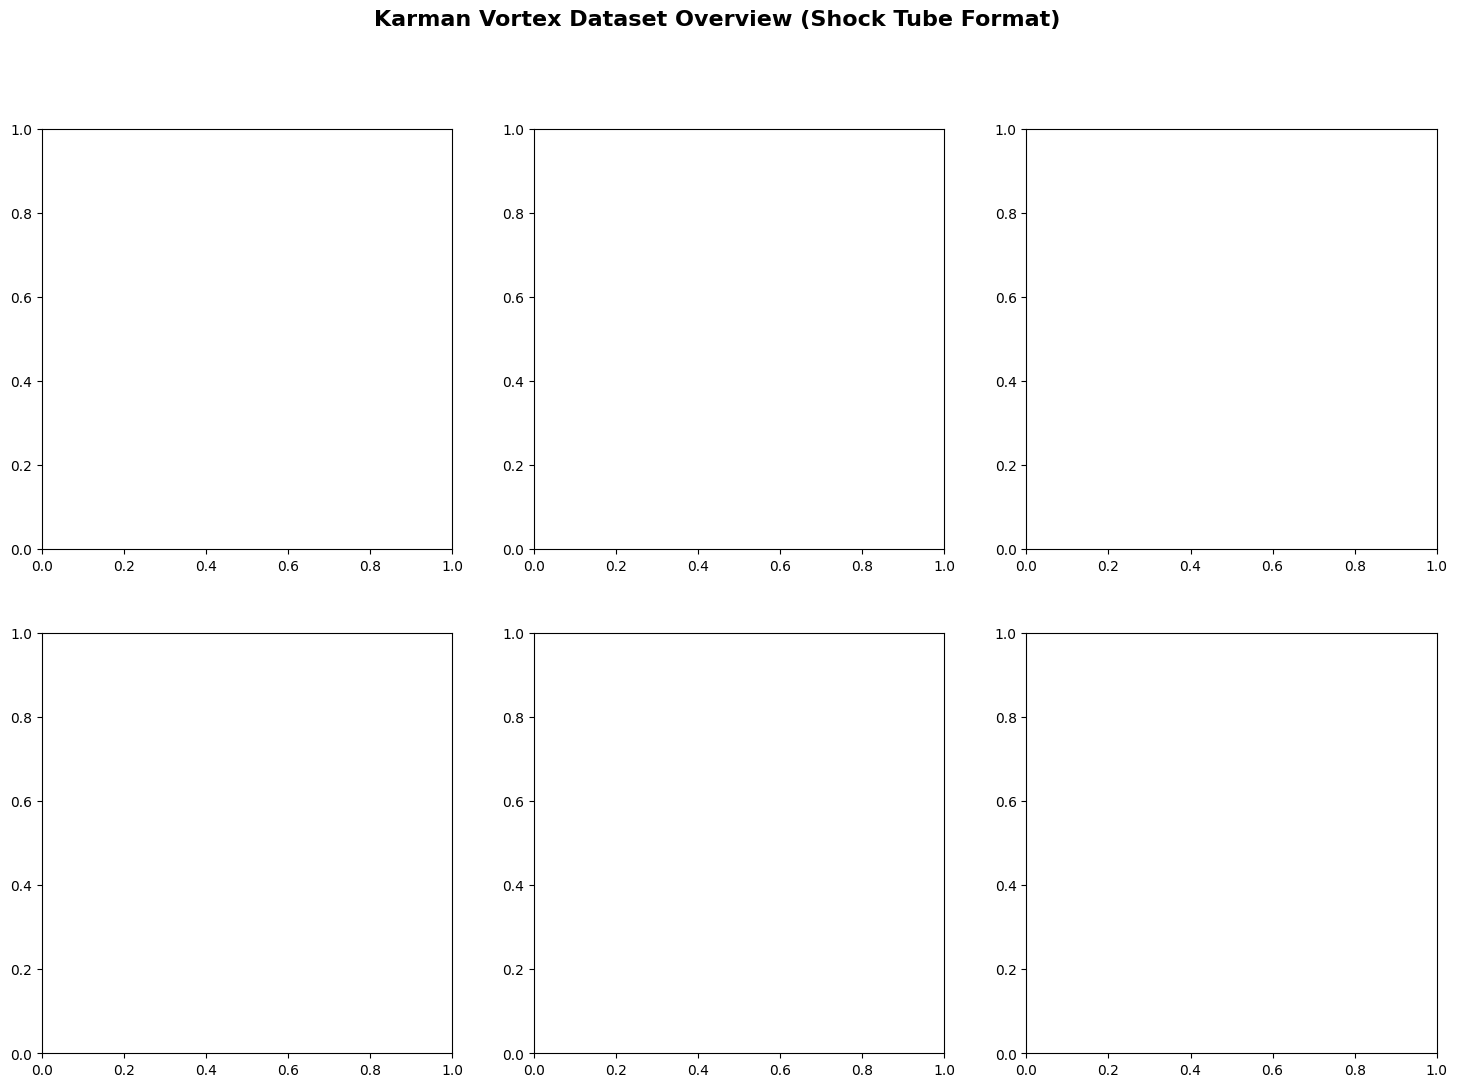

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re

class KarmanDatasetVisualizer:
    """
    Visualizer for analyzing the normalized Karman vortex street datasets.
    Updated for shock tube format: positions + physics in x tensor.
    """
    
    def __init__(self, dataset_dir):
        self.dataset_dir = Path(dataset_dir)
        self.normalized_dir = self.dataset_dir / "normalized"
        
        # Load metadata
        self.metadata = self._load_metadata()
        self.norm_metadata = self._load_normalization_metadata()
        
        # Variable names (shock tube format)
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.var_names = self.position_vars + self.physics_vars
        
        # Set up plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
    def _load_metadata(self):
        """Load the main dataset metadata."""
        metadata_file = self.dataset_dir / "karman_dataset_metadata.json"
        if metadata_file.exists():
            with open(metadata_file, 'r') as f:
                return json.load(f)
        return None
    
    def _load_normalization_metadata(self):
        """Load the normalization metadata."""
        norm_metadata_file = self.normalized_dir / "normalization_metadata.json"
        if norm_metadata_file.exists():
            with open(norm_metadata_file, 'r') as f:
                return json.load(f)
        return None
    
    def visualize_dataset_overview(self):
        """Create an overview visualization of the dataset splits and parameters."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Karman Vortex Dataset Overview (Shock Tube Format)', fontsize=16, fontweight='bold')
        
        # 1. Reynolds number distribution
        ax = axes[0, 0]
        reynolds_nums = self.metadata['reynolds_summary']['unique_values']
        case_counts = [self.metadata['case_sample_counts'][f'Re_{re}'] for re in reynolds_nums]
        
        bars = ax.bar(reynolds_nums, case_counts, alpha=0.7, color='steelblue')
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Number of Timestep Pairs')
        ax.set_title('Dataset Size by Reynolds Number')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, case_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Train/Test/Val split visualization
        ax = axes[0, 1]
        split_info = self.metadata['train_test_val_split']
        split_sizes = split_info['split_sizes']
        
        labels = ['Train', 'Val', 'Test']
        sizes = [split_sizes['train'], split_sizes['val'], split_sizes['test']]
        colors = ['#2ca02c', '#d62728', '#ff7f0e']
        
        non_zero_labels = []
        non_zero_sizes = []
        non_zero_colors = []
        for label, size, color in zip(labels, sizes, colors):
            if size > 0:
                non_zero_labels.append(f'{label}\n({size} samples)')
                non_zero_sizes.append(size)
                non_zero_colors.append(color)
        
        wedges, texts, autotexts = ax.pie(non_zero_sizes, labels=non_zero_labels, 
                                         colors=non_zero_colors, autopct='%1.1f%%',
                                         startangle=90)
        ax.set_title('Train/Test/Val Split Distribution')
        
        # 3. Reynolds assignment by split
        ax = axes[0, 2]
        reynolds_assignment = split_info['reynolds_assignment']
        
        split_reynolds = {
            'Train': reynolds_assignment['train_reynolds'],
            'Val': reynolds_assignment['val_reynolds'], 
            'Test': reynolds_assignment['test_reynolds']
        }
        
        y_pos = np.arange(len(split_reynolds))
        reynolds_text = []
        colors_list = []
        
        for split, reynolds_list in split_reynolds.items():
            if isinstance(reynolds_list, list) and len(reynolds_list) > 0:
                reynolds_text.append(f"Re = {reynolds_list}")
                if split == 'Train':
                    colors_list.append('#2ca02c')
                elif split == 'Val':
                    colors_list.append('#d62728')
                else:
                    colors_list.append('#ff7f0e')
            else:
                reynolds_text.append("None")
                colors_list.append('#cccccc')
        
        bars = ax.barh(y_pos, [1, 1, 1], color=colors_list, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(list(split_reynolds.keys()))
        ax.set_xlabel('Split Assignment')
        ax.set_title('Reynolds Number Assignment by Split')
        
        for i, (bar, text) in enumerate(zip(bars, reynolds_text)):
            ax.text(0.5, bar.get_y() + bar.get_height()/2, text,
                   ha='center', va='center', fontweight='bold', color='white', fontsize=9)
        
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        # 4. Feature dimensions breakdown
        ax = axes[1, 0]
        
        # Get feature info
        sample_case = list(self.metadata['case_info'].values())[0]
        total_features = sample_case['feature_dimensions']['node_features_total']
        pos_features = sample_case['feature_dimensions']['position_features']
        physics_features = sample_case['feature_dimensions']['physics_features']
        global_features = sample_case['feature_dimensions']['global_features']
        
        dimensions = {
            'Position\nFeatures': pos_features,
            'Physics\nFeatures': physics_features, 
            'Global\nFeatures': global_features
        }
        
        dim_names = list(dimensions.keys())
        dim_values = list(dimensions.values())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
        
        bars = ax.bar(dim_names, dim_values, color=colors, alpha=0.7)
        ax.set_ylabel('Number of Features')
        ax.set_title(f'Feature Dimensions (Total in x: {total_features})')
        ax.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, dim_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{value}', ha='center', va='bottom', fontweight='bold')
        
        # 5. Variable ranges
        ax = axes[1, 1]
        
        key_vars = ['pressure', 'velocity_x', 'vorticity_x']
        var_ranges = []
        var_names = []
        
        for var in key_vars:
            if var in self.norm_metadata['normalization_params']:
                orig_range = self.norm_metadata['normalization_params'][var]
                var_ranges.append(orig_range['max'] - orig_range['min'])
                var_names.append(var.replace('_', ' ').title())
        
        bars = ax.bar(var_names, var_ranges, color=['#d62728', '#2ca02c', '#ff7f0e'], alpha=0.7)
        ax.set_ylabel('Original Range Span')
        ax.set_title('Original Variable Ranges')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, var_ranges):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height * 1.05,
                   f'{value:.2e}', ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # 6. Data structure info
        ax = axes[1, 2]
        ax.axis('off')
        
        total_samples = self.metadata['total_samples']
        mesh_info = {
            'Total Samples': f"{total_samples:,}",
            'Reynolds Cases': f"{self.metadata['total_cases']}",
            'Features in x': f"{total_features} (3 pos + 7 phys)",
            'Features in y': f"7 (physics only)",
            'Global params': f"1 (Reynolds)",
            'Format': 'Shock tube compatible'
        }
        
        y_positions = np.linspace(0.9, 0.1, len(mesh_info))
        
        for i, (key, value) in enumerate(mesh_info.items()):
            ax.text(0.1, y_positions[i], f'{key}:', fontsize=11, fontweight='bold')
            ax.text(0.55, y_positions[i], value, fontsize=11)
        
        ax.set_title('Dataset Information')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_normalized_features(self):
        """Analyze the distribution of normalized features (physics only)."""
        samples = {}
        
        # Load train data
        train_file = self.normalized_dir / "karman_vortex_train_normalized.pt"
        if train_file.exists():
            train_data = torch.load(train_file, weights_only=False)
            samples['train'] = train_data[0] if len(train_data) > 0 else None
        
        # Load test data  
        test_file = self.normalized_dir / "karman_vortex_test_normalized.pt"
        if test_file.exists():
            test_data = torch.load(test_file, weights_only=False)
            samples['test'] = test_data[0] if len(test_data) > 0 else None
        
        if not samples:
            print("No normalized data files found!")
            return
        
        sample_data = list(samples.values())[0]
        
        # Get physics feature names (skip first 3 position columns)
        if hasattr(sample_data, 'feature_names'):
            feature_names = sample_data.feature_names
        else:
            feature_names = self.physics_vars
        
        n_features = len(feature_names)
        
        # Create subplot grid
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle('Normalized Physics Feature Distributions', fontsize=16, fontweight='bold')
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten()
        
        # Plot each physics feature (skip first 3 position columns in x)
        for i, feature_name in enumerate(feature_names):
            ax = axes_flat[i]
            
            for split_name, data in samples.items():
                if data is not None:
                    # Get physics features from x (columns 3-9)
                    feature_values = data.x[:, 3 + i].numpy()
                    
                    if len(feature_values) > 5000:
                        feature_values = np.random.choice(feature_values, 5000, replace=False)
                    
                    ax.hist(feature_values, bins=50, alpha=0.6, 
                           label=f'{split_name.title()} (Re={data.reynolds_number})', 
                           density=True)
            
            ax.set_xlabel('Normalized Value')
            ax.set_ylabel('Density')
            ax.set_title(f'{feature_name.replace("_", " ").title()}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)
        
        # Hide unused subplots
        for i in range(n_features, len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_parameter_normalization(self):
        """Visualize the parameter normalization (Reynolds numbers)."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Reynolds Number Normalization', fontsize=16, fontweight='bold')
        
        reynolds_nums = self.metadata['reynolds_summary']['unique_values']
        case_counts = [self.metadata['case_sample_counts'][f'Re_{re}'] for re in reynolds_nums]
        
        # Original Reynolds numbers
        ax = axes[0]
        bars = ax.bar(reynolds_nums, case_counts, alpha=0.7, color='steelblue')
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Number of Samples')
        ax.set_title('Original Reynolds Distribution')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, case_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Normalized Reynolds numbers
        ax = axes[1]
        if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
            re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
            re_min = re_norm_params['min']
            re_max = re_norm_params['max']
            
            normalized_reynolds = [(re - re_min) / (re_max - re_min) for re in reynolds_nums]
            
            bars = ax.bar(normalized_reynolds, case_counts, alpha=0.7, 
                         color='steelblue', width=0.05)
            ax.set_xlabel('Normalized Reynolds Number')
            ax.set_ylabel('Number of Samples')
            ax.set_title('Normalized Reynolds Distribution')
            ax.set_xlim(-0.1, 1.1)
            ax.grid(True, alpha=0.3)
            
            for bar, orig_re, count in zip(bars, reynolds_nums, case_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                       f'Re={orig_re}\n({count})', ha='center', va='bottom', 
                       fontweight='bold', fontsize=9)
        
        # Normalization mapping
        ax = axes[2]
        if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
            re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
            re_min = re_norm_params['min']
            re_max = re_norm_params['max']
            
            original_range = np.linspace(re_min, re_max, 100)
            normalized_range = (original_range - re_min) / (re_max - re_min)
            
            ax.plot(original_range, normalized_range, 'b-', linewidth=2, 
                   label='Normalization Function')
            
            for re_num in reynolds_nums:
                norm_val = (re_num - re_min) / (re_max - re_min)
                ax.plot(re_num, norm_val, 'ro', markersize=10)
                ax.annotate(f'Re={re_num}', (re_num, norm_val), 
                           xytext=(10, 10), textcoords='offset points', fontweight='bold')
            
            ax.set_xlabel('Original Reynolds Number')
            ax.set_ylabel('Normalized Value [0, 1]')
            ax.set_title('Reynolds Number Normalization Mapping')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_individual_cases(self):
        """Analyze the individual normalized case files."""
        individual_cases_dir = self.normalized_dir / "individual_cases_normalized"
        
        if not individual_cases_dir.exists():
            print("Individual normalized cases directory not found!")
            return
        
        case_files = list(individual_cases_dir.glob("*_normalized.pt"))
        
        if not case_files:
            print("No individual normalized case files found!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Individual Normalized Case Analysis', fontsize=16, fontweight='bold')
        
        case_info = {}
        
        for case_file in case_files:
            re_match = re.search(r'Reynolds_(\d+)', case_file.name)
            reynolds_num = int(re_match.group(1)) if re_match else 0
            
            case_data = torch.load(case_file, weights_only=False)
            
            case_info[reynolds_num] = {
                'n_samples': len(case_data),
                'filename': case_file.name,
                'sample_data': case_data[0] if len(case_data) > 0 else None
            }
        
        # 1. Sample counts per case
        ax = axes[0, 0]
        reynolds_list = sorted(case_info.keys())
        sample_counts = [case_info[re]['n_samples'] for re in reynolds_list]
        
        bars = ax.bar(reynolds_list, sample_counts, alpha=0.7, color='steelblue')
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Number of Timestep Pairs')
        ax.set_title('Samples per Individual Case File')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, sample_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # 2. Global parameter values (normalized Reynolds)
        ax = axes[0, 1]
        global_params = []
        
        for reynolds_num in reynolds_list:
            sample = case_info[reynolds_num]['sample_data']
            if sample and hasattr(sample, 'global_params') and sample.global_params is not None:
                global_params.append(sample.global_params[0].item())
            else:
                global_params.append(0)
        
        bars = ax.bar(reynolds_list, global_params, alpha=0.7, color='steelblue')
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Normalized Global Parameter Value')
        ax.set_title('Global Parameter Values (Normalized Reynolds)')
        ax.set_ylim(0, 1.1)
        ax.grid(True, alpha=0.3)
        
        for bar, param_val in zip(bars, global_params):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{param_val:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Feature range verification
        ax = axes[1, 0]
        
        feature_ranges = {}
        
        for reynolds_num in reynolds_list:
            sample = case_info[reynolds_num]['sample_data']
            if sample:
                x_min = sample.x.min().item()
                x_max = sample.x.max().item()
                feature_ranges[reynolds_num] = {'min': x_min, 'max': x_max}
        
        reynolds_nums = list(feature_ranges.keys())
        mins = [feature_ranges[re]['min'] for re in reynolds_nums]
        maxs = [feature_ranges[re]['max'] for re in reynolds_nums]
        
        x_pos = np.arange(len(reynolds_nums))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, mins, width, label='Minimum Values', 
                      alpha=0.7, color='red')
        bars2 = ax.bar(x_pos + width/2, maxs, width, label='Maximum Values', 
                      alpha=0.7, color='blue')
        
        ax.set_xlabel('Reynolds Number')
        ax.set_ylabel('Feature Value Range')
        ax.set_title('Normalized Feature Range Verification')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(reynolds_nums)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='green', linestyle='--', alpha=0.7)
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.7)
        
        # 4. Data structure summary
        ax = axes[1, 1]
        ax.axis('off')
        
        sample = case_info[reynolds_list[0]]['sample_data']
        if sample:
            summary_info = {
                'Nodes per Graph': f"{sample.pos.shape[0]:,}",
                'x features (total)': f"{sample.x.shape[1]} (3 pos + 7 phys)",
                'y features (phys)': f"{sample.y.shape[1]}",
                'Edges': f"{sample.edge_index.shape[1]:,}",
                'Global params': f"{sample.global_params.shape[0] if sample.global_params is not None else 0}",
                'Format': 'Shock tube compatible'
            }
            
            y_positions = np.linspace(0.9, 0.1, len(summary_info))
            
            for i, (key, value) in enumerate(summary_info.items()):
                ax.text(0.1, y_positions[i], f'{key}:', fontsize=11, fontweight='bold')
                ax.text(0.55, y_positions[i], value, fontsize=11)
        
        ax.set_title('Normalized Data Structure')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def create_complete_analysis(self):
        """Create a complete analysis of the dataset."""
        print("Creating complete Karman vortex dataset analysis...")
        
        print("\n1. Dataset Overview")
        self.visualize_dataset_overview()
        
        print("\n2. Normalized Feature Analysis")
        self.analyze_normalized_features()
        
        print("\n3. Parameter Normalization Analysis")
        self.visualize_parameter_normalization()
        
        print("\n4. Individual Case Analysis")
        self.analyze_individual_cases()
        
        print("\nAnalysis complete!")


def analyze_karman_dataset(dataset_dir):
    """
    Analyze a Karman vortex dataset.
    
    Parameters:
    -----------
    dataset_dir : str
        Path to the dataset directory containing metadata and normalized data
    """
    visualizer = KarmanDatasetVisualizer(dataset_dir)
    visualizer.create_complete_analysis()
    return visualizer


if __name__ == "__main__":
    dataset_path = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized"
    
    print("Karman Vortex Street Dataset Visualizer")
    print(f"Analyzing dataset at: {dataset_path}")
    
    visualizer = analyze_karman_dataset(dataset_path)

# New Data

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re

class KarmanDatasetVisualizer:
    """
    Visualizer for analyzing the normalized Karman vortex street datasets.
    Updated for train/test/val folder structure with shock tube format.
    File naming convention: Re_XXX_normalized.pt
    """
    
    def __init__(self, dataset_dir):
        self.dataset_dir = Path(dataset_dir)
        
        # Updated folder structure with separate train/test/val folders
        self.train_dir = self.dataset_dir / "train"
        self.test_dir = self.dataset_dir / "test"
        self.val_dir = self.dataset_dir / "val"
        
        # Load metadata
        self.metadata = self._load_metadata()
        self.norm_metadata = self._load_normalization_metadata()
        
        # Variable names (shock tube format)
        self.position_vars = ['x_pos', 'y_pos', 'z_pos']
        self.physics_vars = ['pressure', 'velocity_x', 'velocity_y', 'velocity_z', 
                           'vorticity_x', 'vorticity_y', 'vorticity_z']
        self.var_names = self.position_vars + self.physics_vars
        
        # Set up plotting style
        plt.style.use('default')
        sns.set_palette("husl")
        
    def _load_metadata(self):
        """Load the main dataset metadata from various possible locations."""
        # Try multiple possible locations
        possible_locations = [
            self.dataset_dir / "karman_dataset_metadata.json",
            self.train_dir / "karman_dataset_metadata.json",
            self.dataset_dir / "metadata" / "karman_dataset_metadata.json",
            self.dataset_dir.parent / "karman_dataset_metadata.json"
        ]
        
        for metadata_file in possible_locations:
            if metadata_file.exists():
                print(f"Found metadata: {metadata_file}")
                with open(metadata_file, 'r') as f:
                    return json.load(f)
        
        print("Warning: Main metadata file not found. Analyzing from actual files.")
        return None
    
    def _load_normalization_metadata(self):
        """Load the normalization metadata from various possible locations."""
        # Try multiple possible locations
        possible_locations = [
            self.train_dir / "normalization_metadata.json",
            self.dataset_dir / "normalization_metadata.json",
            self.dataset_dir / "metadata" / "normalization_metadata.json",
            self.dataset_dir.parent / "normalization_metadata.json"
        ]
        
        for norm_metadata_file in possible_locations:
            if norm_metadata_file.exists():
                print(f"Found normalization metadata: {norm_metadata_file}")
                with open(norm_metadata_file, 'r') as f:
                    return json.load(f)
        
        print("Warning: Normalization metadata file not found. Some visualizations will be limited.")
        return None
    
    def _extract_reynolds_from_filename(self, filename):
        """Extract Reynolds number from filename like Re_150_normalized.pt"""
        re_match = re.search(r'Re_(\d+)', filename)
        return int(re_match.group(1)) if re_match else None
    
    def _load_split_data(self, split_name):
        """Load data from a specific split folder."""
        split_dir = getattr(self, f"{split_name}_dir")
        
        if not split_dir.exists():
            return None
        
        # Look for .pt files in the split directory
        pt_files = list(split_dir.glob("Re_*_normalized.pt"))
        
        if not pt_files:
            print(f"No Re_*_normalized.pt files found in {split_dir}")
            return None
        
        # Load the first file as a sample
        print(f"Loading sample from: {pt_files[0].name}")
        data = torch.load(pt_files[0], weights_only=False)
        return data[0] if len(data) > 0 else None
    
    def _count_samples_in_split(self, split_name):
        """Count total samples across all files in a split."""
        split_dir = getattr(self, f"{split_name}_dir")
        
        if not split_dir.exists():
            return 0
        
        pt_files = list(split_dir.glob("Re_*_normalized.pt"))
        total_samples = 0
        
        for pt_file in pt_files:
            data = torch.load(pt_file, weights_only=False)
            total_samples += len(data)
        
        return total_samples
    
    def visualize_dataset_overview(self):
        """Create an overview visualization of the dataset splits and parameters."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Karman Vortex Dataset Overview (Train/Test/Val Structure)', fontsize=16, fontweight='bold')
        
        # 1. Reynolds number distribution (count from actual files)
        ax = axes[0, 0]
        
        # Always count samples from actual files for accuracy
        train_files = list(self.train_dir.glob("Re_*_normalized.pt")) if self.train_dir.exists() else []
        test_files = list(self.test_dir.glob("Re_*_normalized.pt")) if self.test_dir.exists() else []
        val_files = list(self.val_dir.glob("Re_*_normalized.pt")) if self.val_dir.exists() else []
        
        reynolds_counts = {}
        for file_list in [train_files, test_files, val_files]:
            for file in file_list:
                re_num = self._extract_reynolds_from_filename(file.name)
                if re_num:
                    data = torch.load(file, weights_only=False)
                    reynolds_counts[re_num] = reynolds_counts.get(re_num, 0) + len(data)
        
        if reynolds_counts:
            reynolds_nums = sorted(reynolds_counts.keys())
            case_counts = [reynolds_counts[re] for re in reynolds_nums]
            
            bars = ax.bar(reynolds_nums, case_counts, alpha=0.7, color='steelblue')
            ax.set_xlabel('Reynolds Number')
            ax.set_ylabel('Number of Timestep Pairs')
            ax.set_title('Dataset Size by Reynolds Number')
            ax.grid(True, alpha=0.3)
            
            for bar, count in zip(bars, case_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                       f'{count}', ha='center', va='bottom', fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No data files found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Dataset Size by Reynolds Number')
        
        # 2. Train/Test/Val split visualization
        ax = axes[0, 1]
        
        # Count samples in each split
        train_count = self._count_samples_in_split('train')
        test_count = self._count_samples_in_split('test')
        val_count = self._count_samples_in_split('val')
        
        labels = []
        sizes = []
        colors = []
        
        if train_count > 0:
            labels.append(f'Train\n({train_count} samples)')
            sizes.append(train_count)
            colors.append('#2ca02c')
        
        if val_count > 0:
            labels.append(f'Val\n({val_count} samples)')
            sizes.append(val_count)
            colors.append('#d62728')
        
        if test_count > 0:
            labels.append(f'Test\n({test_count} samples)')
            sizes.append(test_count)
            colors.append('#ff7f0e')
        
        if sizes:
            wedges, texts, autotexts = ax.pie(sizes, labels=labels, 
                                             colors=colors, autopct='%1.1f%%',
                                             startangle=90)
            ax.set_title('Train/Test/Val Split Distribution')
        else:
            ax.text(0.5, 0.5, 'No data found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Train/Test/Val Split Distribution')
        
        # 3. Reynolds assignment by split
        ax = axes[0, 2]
        
        # Determine which Reynolds numbers are in each split
        split_reynolds = {'Train': [], 'Val': [], 'Test': []}
        
        for split_name, split_dir in [('Train', self.train_dir), 
                                       ('Val', self.val_dir), 
                                       ('Test', self.test_dir)]:
            if split_dir.exists():
                pt_files = list(split_dir.glob("Re_*_normalized.pt"))
                reynolds_set = set()
                for file in pt_files:
                    re_num = self._extract_reynolds_from_filename(file.name)
                    if re_num:
                        reynolds_set.add(re_num)
                split_reynolds[split_name] = sorted(list(reynolds_set))
        
        y_pos = np.arange(len(split_reynolds))
        reynolds_text = []
        colors_list = []
        
        for split, reynolds_list in split_reynolds.items():
            if reynolds_list:
                reynolds_text.append(f"Re = {reynolds_list}")
                if split == 'Train':
                    colors_list.append('#2ca02c')
                elif split == 'Val':
                    colors_list.append('#d62728')
                else:
                    colors_list.append('#ff7f0e')
            else:
                reynolds_text.append("None")
                colors_list.append('#cccccc')
        
        bars = ax.barh(y_pos, [1, 1, 1], color=colors_list, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(list(split_reynolds.keys()))
        ax.set_xlabel('Split Assignment')
        ax.set_title('Reynolds Number Assignment by Split')
        
        for i, (bar, text) in enumerate(zip(bars, reynolds_text)):
            ax.text(0.5, bar.get_y() + bar.get_height()/2, text,
                   ha='center', va='center', fontweight='bold', color='white', fontsize=9)
        
        ax.set_xlim(0, 1)
        ax.set_xticks([])
        
        # 4. Feature dimensions breakdown
        ax = axes[1, 0]
        
        # Get feature info from a sample
        sample = self._load_split_data('train')
        if sample is None:
            sample = self._load_split_data('test')
        if sample is None:
            sample = self._load_split_data('val')
        
        if sample:
            total_features = sample.x.shape[1]
            pos_features = 3
            physics_features = total_features - pos_features
            global_features = sample.global_params.shape[0] if hasattr(sample, 'global_params') and sample.global_params is not None else 0
            
            dimensions = {
                'Position\nFeatures': pos_features,
                'Physics\nFeatures': physics_features, 
                'Global\nFeatures': global_features
            }
            
            dim_names = list(dimensions.keys())
            dim_values = list(dimensions.values())
            colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
            
            bars = ax.bar(dim_names, dim_values, color=colors, alpha=0.7)
            ax.set_ylabel('Number of Features')
            ax.set_title(f'Feature Dimensions (Total in x: {total_features})')
            ax.grid(True, alpha=0.3)
            
            for bar, value in zip(bars, dim_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{value}', ha='center', va='bottom', fontweight='bold')
        else:
            ax.text(0.5, 0.5, 'No sample data found', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Feature Dimensions')
        
        # 5. Variable ranges (only if normalization metadata exists)
        ax = axes[1, 1]
        
        if self.norm_metadata and 'normalization_params' in self.norm_metadata:
            key_vars = ['pressure', 'velocity_x', 'vorticity_x']
            var_ranges = []
            var_names = []
            
            for var in key_vars:
                if var in self.norm_metadata['normalization_params']:
                    orig_range = self.norm_metadata['normalization_params'][var]
                    var_ranges.append(orig_range['max'] - orig_range['min'])
                    var_names.append(var.replace('_', ' ').title())
            
            if var_ranges:
                bars = ax.bar(var_names, var_ranges, color=['#d62728', '#2ca02c', '#ff7f0e'], alpha=0.7)
                ax.set_ylabel('Original Range Span')
                ax.set_title('Original Variable Ranges')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(True, alpha=0.3)
                
                for bar, value in zip(bars, var_ranges):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height * 1.05,
                           f'{value:.2e}', ha='center', va='bottom', fontsize=9, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'Variable range data not available', ha='center', va='center', transform=ax.transAxes)
        else:
            # Show actual ranges from loaded data instead
            if sample:
                ax.text(0.5, 0.5, 'Normalization metadata not available\n(showing data structure instead)', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
            else:
                ax.text(0.5, 0.5, 'Normalization metadata not available', 
                       ha='center', va='center', transform=ax.transAxes)
        
        ax.set_title('Original Variable Ranges')
        
        # 6. Data structure info
        ax = axes[1, 2]
        ax.axis('off')
        
        total_samples = train_count + test_count + val_count
        
        if sample:
            mesh_info = {
                'Total Samples': f"{total_samples:,}",
                'Train/Val/Test': f"{train_count}/{val_count}/{test_count}",
                'Features in x': f"{sample.x.shape[1]} (3 pos + {sample.x.shape[1]-3} phys)",
                'Features in y': f"{sample.y.shape[1]}",
                'Nodes per Graph': f"{sample.pos.shape[0]:,}",
                'Global params': f"{sample.global_params.shape[0] if hasattr(sample, 'global_params') and sample.global_params is not None else 0}",
                'Format': 'Shock tube compatible'
            }
        else:
            mesh_info = {
                'Total Samples': f"{total_samples:,}",
                'Train Samples': f"{train_count:,}",
                'Val Samples': f"{val_count:,}",
                'Test Samples': f"{test_count:,}",
                'Format': 'Train/Test/Val folders'
            }
        
        y_positions = np.linspace(0.9, 0.1, len(mesh_info))
        
        for i, (key, value) in enumerate(mesh_info.items()):
            ax.text(0.1, y_positions[i], f'{key}:', fontsize=11, fontweight='bold')
            ax.text(0.55, y_positions[i], value, fontsize=11)
        
        ax.set_title('Dataset Information')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_normalized_features(self):
        """Analyze the distribution of normalized features (physics only)."""
        samples = {}
        
        # Load one sample from each split
        for split_name in ['train', 'test', 'val']:
            sample = self._load_split_data(split_name)
            if sample is not None:
                samples[split_name] = sample
        
        if not samples:
            print("No normalized data files found!")
            return
        
        sample_data = list(samples.values())[0]
        
        # Get physics feature names (skip first 3 position columns)
        if hasattr(sample_data, 'feature_names'):
            feature_names = sample_data.feature_names
        else:
            feature_names = self.physics_vars
        
        n_features = len(feature_names)
        
        # Create subplot grid
        n_cols = 3
        n_rows = (n_features + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
        fig.suptitle('Normalized Physics Feature Distributions', fontsize=16, fontweight='bold')
        
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes_flat = axes.flatten()
        
        # Plot each physics feature (skip first 3 position columns in x)
        for i, feature_name in enumerate(feature_names):
            ax = axes_flat[i]
            
            for split_name, data in samples.items():
                if data is not None:
                    # Get physics features from x (columns 3 onwards)
                    feature_values = data.x[:, 3 + i].numpy()
                    
                    if len(feature_values) > 5000:
                        feature_values = np.random.choice(feature_values, 5000, replace=False)
                    
                    re_num = data.reynolds_number if hasattr(data, 'reynolds_number') else 'Unknown'
                    ax.hist(feature_values, bins=50, alpha=0.6, 
                           label=f'{split_name.title()} (Re={re_num})', 
                           density=True)
            
            ax.set_xlabel('Normalized Value')
            ax.set_ylabel('Density')
            ax.set_title(f'{feature_name.replace("_", " ").title()}')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(0, 1)
        
        # Hide unused subplots
        for i in range(n_features, len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_parameter_normalization(self):
        """Visualize the parameter normalization (Reynolds numbers)."""
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Reynolds Number Normalization', fontsize=16, fontweight='bold')
        
        # Collect Reynolds numbers from all splits
        reynolds_counts = {}
        
        for split_dir in [self.train_dir, self.test_dir, self.val_dir]:
            if split_dir.exists():
                pt_files = list(split_dir.glob("Re_*_normalized.pt"))
                for file in pt_files:
                    re_num = self._extract_reynolds_from_filename(file.name)
                    if re_num:
                        data = torch.load(file, weights_only=False)
                        reynolds_counts[re_num] = reynolds_counts.get(re_num, 0) + len(data)
        
        if not reynolds_counts:
            print("No Reynolds number data found!")
            for ax in axes:
                ax.text(0.5, 0.5, 'No data found', ha='center', va='center', transform=ax.transAxes)
            plt.tight_layout()
            plt.show()
            return
        
        reynolds_nums = sorted(reynolds_counts.keys())
        case_counts = [reynolds_counts[re] for re in reynolds_nums]
        
        # Original Reynolds numbers
        ax = axes[0]
        bars = ax.bar(reynolds_nums, case_counts, alpha=0.7, color='steelblue')
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Number of Samples')
        ax.set_title('Original Reynolds Distribution')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, case_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                   f'{count}', ha='center', va='bottom', fontweight='bold')
        
        # Normalized Reynolds numbers (if metadata available)
        ax = axes[1]
        if self.norm_metadata and 'global_param_normalization' in self.norm_metadata:
            if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
                re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
                re_min = re_norm_params['min']
                re_max = re_norm_params['max']
                
                normalized_reynolds = [(re - re_min) / (re_max - re_min) for re in reynolds_nums]
                
                bars = ax.bar(normalized_reynolds, case_counts, alpha=0.7, 
                             color='steelblue', width=0.05)
                ax.set_xlabel('Normalized Reynolds Number')
                ax.set_ylabel('Number of Samples')
                ax.set_title('Normalized Reynolds Distribution')
                ax.set_xlim(-0.1, 1.1)
                ax.grid(True, alpha=0.3)
                
                for bar, orig_re, count in zip(bars, reynolds_nums, case_counts):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                           f'Re={orig_re}\n({count})', ha='center', va='bottom', 
                           fontweight='bold', fontsize=9)
            else:
                ax.text(0.5, 0.5, 'Reynolds normalization\ndata not in metadata', 
                       ha='center', va='center', transform=ax.transAxes)
        else:
            # Try to infer from actual data
            sample_file = None
            for split_dir in [self.train_dir, self.test_dir, self.val_dir]:
                if split_dir.exists():
                    files = list(split_dir.glob("Re_*_normalized.pt"))
                    if files:
                        sample_file = files[0]
                        break
            
            if sample_file:
                data = torch.load(sample_file, weights_only=False)
                if len(data) > 0 and hasattr(data[0], 'global_params') and data[0].global_params is not None:
                    ax.text(0.5, 0.5, f'Normalization metadata not available\n(Sample global_params: {data[0].global_params[0].item():.3f})', 
                           ha='center', va='center', transform=ax.transAxes, fontsize=10)
                else:
                    ax.text(0.5, 0.5, 'Normalization metadata not available', 
                           ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, 'Normalization metadata not available', 
                       ha='center', va='center', transform=ax.transAxes)
        
        # Normalization mapping
        ax = axes[2]
        if self.norm_metadata and 'global_param_normalization' in self.norm_metadata:
            if 'reynolds_number' in self.norm_metadata['global_param_normalization']:
                re_norm_params = self.norm_metadata['global_param_normalization']['reynolds_number']
                re_min = re_norm_params['min']
                re_max = re_norm_params['max']
                
                original_range = np.linspace(re_min, re_max, 100)
                normalized_range = (original_range - re_min) / (re_max - re_min)
                
                ax.plot(original_range, normalized_range, 'b-', linewidth=2, 
                       label='Normalization Function')
                
                for re_num in reynolds_nums:
                    norm_val = (re_num - re_min) / (re_max - re_min)
                    ax.plot(re_num, norm_val, 'ro', markersize=10)
                    ax.annotate(f'Re={re_num}', (re_num, norm_val), 
                               xytext=(10, 10), textcoords='offset points', fontweight='bold')
                
                ax.set_xlabel('Original Reynolds Number')
                ax.set_ylabel('Normalized Value [0, 1]')
                ax.set_title('Reynolds Number Normalization Mapping')
                ax.grid(True, alpha=0.3)
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'Reynolds normalization\ndata not in metadata', 
                       ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'Normalization metadata not available', 
                   ha='center', va='center', transform=ax.transAxes)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_individual_cases(self):
        """Analyze the individual normalized case files across all splits."""
        case_info = {}
        
        # Collect all case files from all splits
        for split_name, split_dir in [('train', self.train_dir), 
                                       ('val', self.val_dir), 
                                       ('test', self.test_dir)]:
            if split_dir.exists():
                case_files = list(split_dir.glob("Re_*_normalized.pt"))
                
                for case_file in case_files:
                    re_num = self._extract_reynolds_from_filename(case_file.name)
                    if re_num is None:
                        continue
                    
                    case_data = torch.load(case_file, weights_only=False)
                    
                    key = f"{re_num}_{split_name}"
                    case_info[key] = {
                        'reynolds': re_num,
                        'split': split_name,
                        'n_samples': len(case_data),
                        'filename': case_file.name,
                        'sample_data': case_data[0] if len(case_data) > 0 else None
                    }
        
        if not case_info:
            print("No individual case files found!")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Individual Case Analysis (All Splits)', fontsize=16, fontweight='bold')
        
        # 1. Sample counts per case with split coloring
        ax = axes[0, 0]
        
        sorted_cases = sorted(case_info.items(), key=lambda x: (x[1]['reynolds'], x[1]['split']))
        labels = [f"Re={info['reynolds']}\n({info['split']})" for _, info in sorted_cases]
        sample_counts = [info['n_samples'] for _, info in sorted_cases]
        colors = ['#2ca02c' if info['split'] == 'train' else 
                 '#d62728' if info['split'] == 'val' else '#ff7f0e' 
                 for _, info in sorted_cases]
        
        x_pos = np.arange(len(labels))
        bars = ax.bar(x_pos, sample_counts, alpha=0.7, color=colors)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_ylabel('Number of Timestep Pairs')
        ax.set_title('Samples per Case File (Colored by Split)')
        ax.grid(True, alpha=0.3)
        
        for bar, count in zip(bars, sample_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        
        # 2. Global parameter values by split
        ax = axes[0, 1]
        
        for split_name, split_color in [('train', '#2ca02c'), ('val', '#d62728'), ('test', '#ff7f0e')]:
            split_cases = [(info['reynolds'], info['sample_data']) 
                          for info in case_info.values() if info['split'] == split_name]
            
            if split_cases:
                reynolds_list = [re for re, _ in split_cases]
                global_params = []
                
                for _, sample in split_cases:
                    if sample and hasattr(sample, 'global_params') and sample.global_params is not None:
                        global_params.append(sample.global_params[0].item())
                    else:
                        global_params.append(0)
                
                ax.scatter(reynolds_list, global_params, alpha=0.7, s=100, 
                          label=split_name.title(), color=split_color)
        
        ax.set_xlabel('Original Reynolds Number')
        ax.set_ylabel('Normalized Global Parameter Value')
        ax.set_title('Global Parameter Values by Split')
        ax.set_ylim(-0.1, 1.1)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # 3. Feature range verification
        ax = axes[1, 0]
        
        feature_ranges = {}
        
        for key, info in case_info.items():
            sample = info['sample_data']
            if sample:
                x_min = sample.x.min().item()
                x_max = sample.x.max().item()
                feature_ranges[key] = {
                    'min': x_min, 
                    'max': x_max,
                    'reynolds': info['reynolds'],
                    'split': info['split']
                }
        
        sorted_ranges = sorted(feature_ranges.items(), key=lambda x: (x[1]['reynolds'], x[1]['split']))
        
        labels = [f"Re={info['reynolds']}\n({info['split']})" for _, info in sorted_ranges]
        mins = [info['min'] for _, info in sorted_ranges]
        maxs = [info['max'] for _, info in sorted_ranges]
        colors = ['#2ca02c' if info['split'] == 'train' else 
                 '#d62728' if info['split'] == 'val' else '#ff7f0e' 
                 for _, info in sorted_ranges]
        
        x_pos = np.arange(len(labels))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, mins, width, label='Min', alpha=0.7, color='red')
        bars2 = ax.bar(x_pos + width/2, maxs, width, label='Max', alpha=0.7, color='blue')
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_ylabel('Feature Value Range')
        ax.set_title('Normalized Feature Range Verification')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Expected min (0)')
        ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Expected max (1)')
        
        # 4. Data structure summary
        ax = axes[1, 1]
        ax.axis('off')
        
        # Use first available sample
        sample = None
        for info in case_info.values():
            if info['sample_data'] is not None:
                sample = info['sample_data']
                break
        
        if sample:
            total_samples = sum(info['n_samples'] for info in case_info.values())
            n_train = sum(info['n_samples'] for info in case_info.values() if info['split'] == 'train')
            n_val = sum(info['n_samples'] for info in case_info.values() if info['split'] == 'val')
            n_test = sum(info['n_samples'] for info in case_info.values() if info['split'] == 'test')
            
            summary_info = {
                'Total Samples': f"{total_samples:,}",
                'Train/Val/Test': f"{n_train}/{n_val}/{n_test}",
                'Nodes per Graph': f"{sample.pos.shape[0]:,}",
                'x features': f"{sample.x.shape[1]} (3 pos + {sample.x.shape[1]-3} phys)",
                'y features': f"{sample.y.shape[1]}",
                'Edges': f"{sample.edge_index.shape[1]:,}",
                'Global params': f"{sample.global_params.shape[0] if sample.global_params is not None else 0}",
                'Format': 'Shock tube compatible'
            }
            
            y_positions = np.linspace(0.9, 0.1, len(summary_info))
            
            for i, (key, value) in enumerate(summary_info.items()):
                ax.text(0.1, y_positions[i], f'{key}:', fontsize=11, fontweight='bold')
                ax.text(0.6, y_positions[i], value, fontsize=11)
        
        ax.set_title('Data Structure Summary')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        
        plt.tight_layout()
        plt.show()
    
    def create_complete_analysis(self):
        """Create a complete analysis of the dataset."""
        print("Creating complete Karman vortex dataset analysis...")
        print(f"Files expected: Re_XXX_normalized.pt format")
        
        print("\n1. Dataset Overview")
        self.visualize_dataset_overview()
        
        print("\n2. Normalized Feature Analysis")
        self.analyze_normalized_features()
        
        print("\n3. Parameter Normalization Analysis")
        self.visualize_parameter_normalization()
        
        print("\n4. Individual Case Analysis")
        self.analyze_individual_cases()
        
        print("\nAnalysis complete!")

def analyze_karman_dataset(dataset_dir):
    """
    Analyze a Karman vortex dataset with train/test/val folder structure.
    
    Parameters:
    -----------
    dataset_dir : str
        Path to the dataset directory containing train, test, and val folders
        Files should be named: Re_XXX_normalized.pt
    """
    visualizer = KarmanDatasetVisualizer(dataset_dir)
    visualizer.create_complete_analysis()
    return visualizer

if __name__ == "__main__":
    dataset_path = "/standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized"
    
    print("Karman Vortex Street Dataset Visualizer")
    print(f"Analyzing dataset at: {dataset_path}")
    print("-" * 60)
    
    visualizer = analyze_karman_dataset(dataset_path)

Karman Vortex Street Dataset Visualizer
Analyzing dataset at: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized
------------------------------------------------------------
Found metadata: /standard/sds_baek_energetic/von_karman_vortex/full_data/split_normalized/karman_dataset_metadata.json
Creating complete Karman vortex dataset analysis...
Files expected: Re_XXX_normalized.pt format

1. Dataset Overview


In [1]:
import torch
import numpy as np
from pathlib import Path

def inspect_karman_training_data(train_dir="/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train/"):
    """Inspect normalized Karman vortex training data for issues."""
    
    train_path = Path(train_dir)
    
    if not train_path.exists():
        print(f"Directory not found: {train_path}")
        return
    
    # Find all .pt files
    data_files = list(train_path.glob("*.pt"))
    print(f"Found {len(data_files)} training files")
    print(f"Files: {[f.name for f in data_files[:5]]}")
    
    if not data_files:
        print("No .pt files found!")
        return
    
    # Load and inspect first file
    first_file = data_files[0]
    print(f"\n{'='*60}")
    print(f"Inspecting: {first_file.name}")
    print(f"{'='*60}")
    
    data = torch.load(first_file, weights_only=False)
    
    if not isinstance(data, list):
        print(f"Unexpected format: {type(data)}")
        return
    
    print(f"Total timesteps in file: {len(data)}")
    
    # Inspect first timestep
    sample = data[0]
    print(f"\nFirst timestep structure:")
    print(f"  Type: {type(sample)}")
    print(f"  Attributes: {dir(sample)}")
    
    # Check shapes
    print(f"\nTensor shapes:")
    print(f"  x.shape: {sample.x.shape}")
    print(f"  y.shape: {sample.y.shape}")
    if hasattr(sample, 'pos'):
        print(f"  pos.shape: {sample.pos.shape}")
    if hasattr(sample, 'edge_index'):
        print(f"  edge_index.shape: {sample.edge_index.shape}")
    if hasattr(sample, 'global_params'):
        print(f"  global_params.shape: {sample.global_params.shape}")
        print(f"  global_params value: {sample.global_params}")
    
    # Check for metadata
    if hasattr(sample, 'reynolds_number'):
        print(f"  reynolds_number: {sample.reynolds_number}")
    
    # Detailed statistics on x tensor
    print(f"\n{'='*60}")
    print(f"X TENSOR STATISTICS (Input features)")
    print(f"{'='*60}")
    
    x = sample.x
    print(f"Shape: {x.shape} (nodes, features)")
    print(f"\nPer-feature statistics (first 10 features):")
    
    feature_names = ['x_pos', 'y_pos', 'z_pos', 'pressure', 'vel_x', 'vel_y', 'vel_z', 'vort_x', 'vort_y', 'vort_z']
    
    for i in range(min(x.shape[1], 10)):
        feat = x[:, i]
        name = feature_names[i] if i < len(feature_names) else f"feat_{i}"
        
        has_nan = torch.isnan(feat).any().item()
        has_inf = torch.isinf(feat).any().item()
        
        print(f"\n  [{i}] {name}:")
        print(f"    min={feat.min().item():.6f}, max={feat.max().item():.6f}")
        print(f"    mean={feat.mean().item():.6f}, std={feat.std().item():.6f}")
        print(f"    NaN: {has_nan}, Inf: {has_inf}")
        
        if has_nan or has_inf:
            print(f"    ⚠️ WARNING: Contains NaN or Inf!")
    
    # Check y tensor
    print(f"\n{'='*60}")
    print(f"Y TENSOR STATISTICS (Target/labels)")
    print(f"{'='*60}")
    
    y = sample.y
    print(f"Shape: {y.shape} (nodes, features)")
    print(f"\nPer-feature statistics:")
    
    target_names = ['pressure', 'vel_x', 'vel_y', 'vel_z', 'vort_x', 'vort_y', 'vort_z']
    
    for i in range(y.shape[1]):
        feat = y[:, i]
        name = target_names[i] if i < len(target_names) else f"target_{i}"
        
        has_nan = torch.isnan(feat).any().item()
        has_inf = torch.isinf(feat).any().item()
        
        print(f"\n  [{i}] {name}:")
        print(f"    min={feat.min().item():.6f}, max={feat.max().item():.6f}")
        print(f"    mean={feat.mean().item():.6f}, std={feat.std().item():.6f}")
        print(f"    NaN: {has_nan}, Inf: {has_inf}")
        
        if has_nan or has_inf:
            print(f"    ⚠️ WARNING: Contains NaN or Inf!")
    
    # Check multiple timesteps for consistency
    print(f"\n{'='*60}")
    print(f"CHECKING MULTIPLE TIMESTEPS")
    print(f"{'='*60}")
    
    issues_found = []
    
    for t in range(min(10, len(data))):
        sample_t = data[t]
        
        if torch.isnan(sample_t.x).any():
            issues_found.append(f"Timestep {t}: NaN in x")
        if torch.isinf(sample_t.x).any():
            issues_found.append(f"Timestep {t}: Inf in x")
        if torch.isnan(sample_t.y).any():
            issues_found.append(f"Timestep {t}: NaN in y")
        if torch.isinf(sample_t.y).any():
            issues_found.append(f"Timestep {t}: Inf in y")
        
        # Check if values are reasonable (should be in [0, 1] if normalized)
        if sample_t.x.min() < -0.1 or sample_t.x.max() > 1.1:
            issues_found.append(f"Timestep {t}: x values outside [0,1] range: [{sample_t.x.min():.3f}, {sample_t.x.max():.3f}]")
        if sample_t.y.min() < -0.1 or sample_t.y.max() > 1.1:
            issues_found.append(f"Timestep {t}: y values outside [0,1] range: [{sample_t.y.min():.3f}, {sample_t.y.max():.3f}]")
    
    if issues_found:
        print("\n⚠️ ISSUES FOUND:")
        for issue in issues_found:
            print(f"  - {issue}")
    else:
        print("\n✓ No obvious issues in first 10 timesteps")
    
    # Check all files briefly
    print(f"\n{'='*60}")
    print(f"SCANNING ALL FILES")
    print(f"{'='*60}")
    
    for file_path in data_files[:5]:  # Check first 5 files
        try:
            file_data = torch.load(file_path, weights_only=False)
            sample = file_data[0]
            
            has_issues = (
                torch.isnan(sample.x).any() or 
                torch.isinf(sample.x).any() or
                torch.isnan(sample.y).any() or 
                torch.isinf(sample.y).any()
            )
            
            status = "⚠️ HAS ISSUES" if has_issues else "✓"
            print(f"{status} {file_path.name}: {len(file_data)} timesteps, x={sample.x.shape}, y={sample.y.shape}")
            
        except Exception as e:
            print(f"✗ {file_path.name}: Error loading - {e}")

if __name__ == "__main__":
    inspect_karman_training_data()

Found 6 training files
Files: ['Reynolds_20_raw_data_normalized.pt', 'Reynolds_50_raw_data_normalized.pt', 'Reynolds_150_raw_data_normalized.pt', 'Reynolds_100_raw_data_normalized.pt', 'Reynolds_40_raw_data_normalized.pt']

Inspecting: Reynolds_20_raw_data_normalized.pt


/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /sfs/gpfs/tardis/home/jtb3sud/.local/lib/python3.11/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/jtb3sud/.local/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /sfs/gpfs/tardis/home/jtb3sud/.local/lib/python3.11/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _

Total timesteps in file: 400

First timestep structure:
  Type: <class 'torch_geometric.data.data.Data'>
  Attributes: ['__abstractmethods__', '__annotations__', '__call__', '__cat_dim__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__inc__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_edge_attr_cls', '_edge_to_layout', '_edges_to_layout', '_get_edge_index', '_get_tensor', '_get_tensor_size', '_multi_get_tensor', '_put_edge_index', '_put_tensor', '_remove_edge_index', '_remove_tensor', '_store', '_tensor_attr_cls', '_to_type', 'apply', 'apply_', 'bat

In [5]:
"""
Jupyter Notebook for Visualizing Cylinder Flow - GIF Export Version
====================================================================
Creates actual GIF files saved to disk.
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path

# ============================================================================
# CELL 1: Load Data
# ============================================================================

simulation_file = "/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train/Reynolds_20_raw_data_normalized.pt"
simulation = torch.load(simulation_file, weights_only=False)

print(f"Loaded simulation with {len(simulation)} timesteps")
print(f"First timestep has {simulation[0].num_nodes} nodes")
print(f"Feature shape: {simulation[0].x.shape}")

# ============================================================================
# CELL 2: Extract Information
# ============================================================================

n_timesteps = len(simulation)
n_nodes = simulation[0].num_nodes
n_features = simulation[0].x.shape[1]
positions = simulation[0].x[:, :3].numpy()

reynolds = None
if hasattr(simulation[0], 'global_params'):
    reynolds = float(simulation[0].global_params[0])
elif hasattr(simulation[0], 'reynolds'):
    reynolds = float(simulation[0].reynolds)

print(f"\nTimesteps: {n_timesteps}")
print(f"Nodes: {n_nodes}")
print(f"Reynolds: {reynolds if reynolds else 'Not found'}")

# ============================================================================
# CELL 3: Configuration
# ============================================================================

num_static_feats = 3
num_dynamic_feats = 7

var_names = [
    'pressure',
    'x_velocity', 
    'y_velocity',
    'z_velocity',
    'x_vorticity', 
    'y_vorticity',
    'z_vorticity'
]

# Subsampling settings
max_viz_nodes = 10000
timestep_skip = 10

if max_viz_nodes and n_nodes > max_viz_nodes:
    node_indices = np.random.choice(n_nodes, max_viz_nodes, replace=False)
    node_indices = np.sort(node_indices)
    positions_viz = positions[node_indices]
else:
    node_indices = np.arange(n_nodes)
    positions_viz = positions

timesteps_to_viz = list(range(0, n_timesteps, timestep_skip))
positions_2d = positions_viz[:, :2]

print(f"\nVisualizing {len(timesteps_to_viz)} timesteps")
print(f"Using {len(node_indices)} nodes")

# ============================================================================
# CELL 4: Create Single Variable GIF
# ============================================================================

def create_single_var_gif(var_idx, output_dir='./gifs', fps=5, dpi=100):
    """Create and save GIF for a single variable."""
    
    Path(output_dir).mkdir(exist_ok=True)
    
    var_name = var_names[var_idx]
    filename = f"{output_dir}/Re{int(reynolds) if reynolds else 'unknown'}_{var_name}.gif"
    
    print(f"\nCreating GIF: {filename}")
    print(f"  Variable: {var_name}")
    print(f"  Frames: {len(timesteps_to_viz)}")
    
    # Get data range
    sample_indices = timesteps_to_viz[::max(1, len(timesteps_to_viz)//10)]
    all_values = []
    for i in sample_indices:
        data = simulation[i].x[node_indices, num_static_feats + var_idx].numpy()
        all_values.extend(data)
    vmin, vmax = np.percentile(all_values, [2, 98])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), dpi=dpi)
    
    initial_data = simulation[timesteps_to_viz[0]].x[node_indices, num_static_feats + var_idx].numpy()
    scatter = ax.scatter(positions_2d[:, 0], positions_2d[:, 1], 
                        c=initial_data, cmap='viridis', s=1.0,
                        vmin=vmin, vmax=vmax, alpha=0.8, rasterized=True)
    
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_aspect('equal')
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(var_name.replace('_', ' ').title(), fontsize=12)
    
    title = ax.set_title(
        f'{var_name.replace("_", " ").title()} - Timestep {timesteps_to_viz[0]}' +
        (f' (Re={reynolds:.0f})' if reynolds else ''),
        fontsize=14
    )
    
    def animate(frame_num):
        actual_idx = timesteps_to_viz[frame_num]
        data = simulation[actual_idx].x[node_indices, num_static_feats + var_idx].numpy()
        scatter.set_array(data)
        title.set_text(
            f'{var_name.replace("_", " ").title()} - Timestep {actual_idx}' +
            (f' (Re={reynolds:.0f})' if reynolds else '')
        )
        return scatter, title
    
    anim = FuncAnimation(fig, animate, frames=len(timesteps_to_viz),
                        interval=1000//fps, blit=False)
    
    writer = PillowWriter(fps=fps)
    anim.save(filename, writer=writer, dpi=dpi)
    plt.close()
    
    print(f"  ✓ Saved: {filename}")
    return filename

# Create GIF for pressure
create_single_var_gif(var_idx=0, output_dir='./cylinder_gifs', fps=5, dpi=100)

# ============================================================================
# CELL 5: Create Multi-Variable GIF
# ============================================================================

def create_multi_var_gif(var_indices=[0, 1, 2], output_dir='./gifs', fps=5, dpi=100):
    """Create and save side-by-side GIF for multiple variables."""
    
    Path(output_dir).mkdir(exist_ok=True)
    
    selected_vars = [var_names[i] for i in var_indices]
    var_string = "_".join([var_names[i] for i in var_indices])
    filename = f"{output_dir}/Re{int(reynolds) if reynolds else 'unknown'}_multi_{var_string}.gif"
    
    print(f"\nCreating multi-variable GIF: {filename}")
    print(f"  Variables: {selected_vars}")
    print(f"  Frames: {len(timesteps_to_viz)}")
    
    # Get data ranges
    vranges = []
    for var_idx in var_indices:
        sample_indices = timesteps_to_viz[::max(1, len(timesteps_to_viz)//10)]
        all_values = []
        for i in sample_indices:
            data = simulation[i].x[node_indices, num_static_feats + var_idx].numpy()
            all_values.extend(data)
        vmin, vmax = np.percentile(all_values, [2, 98])
        vranges.append((vmin, vmax))
    
    # Create figure
    n_vars = len(var_indices)
    fig, axes = plt.subplots(1, n_vars, figsize=(6*n_vars, 6), dpi=dpi)
    if n_vars == 1:
        axes = [axes]
    
    scatters = []
    
    for i, (ax, var_idx) in enumerate(zip(axes, var_indices)):
        initial_data = simulation[timesteps_to_viz[0]].x[node_indices, num_static_feats + var_idx].numpy()
        
        scatter = ax.scatter(positions_2d[:, 0], positions_2d[:, 1], 
                           c=initial_data, cmap='viridis', s=1.0,
                           vmin=vranges[i][0], vmax=vranges[i][1], 
                           alpha=0.8, rasterized=True)
        
        ax.set_xlabel('X', fontsize=10)
        ax.set_ylabel('Y', fontsize=10)
        ax.set_aspect('equal')
        ax.set_title(var_names[var_idx].replace('_', ' ').title(), fontsize=12)
        
        plt.colorbar(scatter, ax=ax)
        scatters.append(scatter)
    
    main_title = fig.suptitle(
        f'Timestep {timesteps_to_viz[0]}' + (f' (Re={reynolds:.0f})' if reynolds else ''),
        fontsize=14
    )
    
    def animate(frame_num):
        actual_idx = timesteps_to_viz[frame_num]
        
        for i, var_idx in enumerate(var_indices):
            data = simulation[actual_idx].x[node_indices, num_static_feats + var_idx].numpy()
            scatters[i].set_array(data)
        
        main_title.set_text(
            f'Timestep {actual_idx}' + (f' (Re={reynolds:.0f})' if reynolds else '')
        )
        return scatters + [main_title]
    
    anim = FuncAnimation(fig, animate, frames=len(timesteps_to_viz),
                        interval=1000//fps, blit=False)
    
    writer = PillowWriter(fps=fps)
    anim.save(filename, writer=writer, dpi=dpi)
    plt.close()
    
    print(f"  ✓ Saved: {filename}")
    return filename

# Create multi-variable GIF
create_multi_var_gif(var_indices=[0, 1, 2], output_dir='./cylinder_gifs', fps=5, dpi=100)

# ============================================================================
# CELL 6: Batch Create All Variables
# ============================================================================

def create_all_gifs(output_dir='./cylinder_gifs', fps=5, dpi=100):
    """Create GIFs for all 7 variables."""
    
    print(f"\nCreating GIFs for all {len(var_names)} variables...")
    print(f"Output directory: {output_dir}")
    
    created_files = []
    
    for i, var_name in enumerate(var_names):
        try:
            filename = create_single_var_gif(i, output_dir=output_dir, fps=fps, dpi=dpi)
            created_files.append(filename)
        except Exception as e:
            print(f"  ✗ Error creating GIF for {var_name}: {e}")
    
    print(f"\n{'='*60}")
    print(f"Summary: Created {len(created_files)}/{len(var_names)} GIFs")
    print(f"{'='*60}")
    for f in created_files:
        print(f"  {f}")
    
    return created_files

# Create all GIFs
all_gif_files = create_all_gifs(output_dir='./cylinder_gifs', fps=5, dpi=100)

# ============================================================================
# CELL 7: Statistics Summary
# ============================================================================

def compute_statistics():
    """Compute statistics across sampled timesteps."""
    
    print("\n" + "="*70)
    print("VARIABLE STATISTICS")
    print("="*70)
    
    stats = {var: {'min': [], 'max': [], 'mean': [], 'std': []} 
            for var in var_names}
    
    for t in timesteps_to_viz:
        dynamic_data = simulation[t].x[:, num_static_feats:num_static_feats + num_dynamic_feats]
        
        for i, var in enumerate(var_names):
            data = dynamic_data[:, i].numpy()
            stats[var]['min'].append(data.min())
            stats[var]['max'].append(data.max())
            stats[var]['mean'].append(data.mean())
            stats[var]['std'].append(data.std())
    
    for var in var_names:
        print(f"\n{var.replace('_', ' ').title()}:")
        print(f"  Range: [{np.min(stats[var]['min']):.4e}, {np.max(stats[var]['max']):.4e}]")
        print(f"  Mean:  {np.mean(stats[var]['mean']):.4e} ± {np.mean(stats[var]['std']):.4e}")
    
    print(f"\n{'='*70}")

compute_statistics()

Loaded simulation with 400 timesteps
First timestep has 60746 nodes
Feature shape: torch.Size([60746, 10])

Timesteps: 400
Nodes: 60746
Reynolds: 0.12751677632331848

Visualizing 40 timesteps
Using 10000 nodes

Creating GIF: ./cylinder_gifs/Re0_pressure.gif
  Variable: pressure
  Frames: 40
  ✓ Saved: ./cylinder_gifs/Re0_pressure.gif

Creating multi-variable GIF: ./cylinder_gifs/Re0_multi_pressure_x_velocity_y_velocity.gif
  Variables: ['pressure', 'x_velocity', 'y_velocity']
  Frames: 40
  ✓ Saved: ./cylinder_gifs/Re0_multi_pressure_x_velocity_y_velocity.gif

Creating GIFs for all 7 variables...
Output directory: ./cylinder_gifs

Creating GIF: ./cylinder_gifs/Re0_pressure.gif
  Variable: pressure
  Frames: 40
  ✓ Saved: ./cylinder_gifs/Re0_pressure.gif

Creating GIF: ./cylinder_gifs/Re0_x_velocity.gif
  Variable: x_velocity
  Frames: 40
  ✓ Saved: ./cylinder_gifs/Re0_x_velocity.gif

Creating GIF: ./cylinder_gifs/Re0_y_velocity.gif
  Variable: y_velocity
  Frames: 40
  ✓ Saved: ./cylin

In [4]:
import torch
import numpy as np
from pathlib import Path

def analyze_feature_importance(train_dir="/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train/"):
    """
    Analyze which dynamic features are actually varying and important.
    Identifies constant or near-constant features that can be skipped.
    """
    
    train_path = Path(train_dir)
    
    if not train_path.exists():
        print(f"Directory not found: {train_path}")
        return
    
    data_files = list(train_path.glob("*.pt"))
    print(f"Found {len(data_files)} training files\n")
    
    if not data_files:
        print("No .pt files found!")
        return
    
    # Feature names
    static_feature_names = ['x_pos', 'y_pos', 'z_pos']
    dynamic_feature_names = [
        'pressure',
        'x_velocity', 
        'y_velocity',
        'z_velocity',
        'x_vorticity', 
        'y_vorticity',
        'z_vorticity'
    ]
    
    print("="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Analyze multiple files for robustness
    files_to_analyze = min(5, len(data_files))
    print(f"\nAnalyzing {files_to_analyze} files for feature statistics...\n")
    
    # Collect statistics across files
    dynamic_stats = {name: {'values': [], 'ranges': [], 'stds': [], 'variances': []} 
                    for name in dynamic_feature_names}
    
    for file_idx, file_path in enumerate(data_files[:files_to_analyze]):
        print(f"Processing {file_path.name}...")
        
        data = torch.load(file_path, weights_only=False)
        
        # Sample timesteps throughout the simulation
        timestep_samples = np.linspace(0, len(data)-1, min(10, len(data)), dtype=int)
        
        for t in timestep_samples:
            sample = data[t]
            
            # Assuming structure: [static_features, dynamic_features]
            num_static = 3
            dynamic_data = sample.x[:, num_static:num_static+7]
            
            for i, name in enumerate(dynamic_feature_names):
                feat = dynamic_data[:, i].numpy()
                
                dynamic_stats[name]['values'].extend(feat.flatten().tolist()[:1000])  # Sample 1000 nodes
                dynamic_stats[name]['ranges'].append(feat.max() - feat.min())
                dynamic_stats[name]['stds'].append(feat.std())
                dynamic_stats[name]['variances'].append(feat.var())
    
    print("\n" + "="*80)
    print("DYNAMIC FEATURE ANALYSIS RESULTS")
    print("="*80)
    
    # Analyze each feature
    feature_importance = []
    
    for i, name in enumerate(dynamic_feature_names):
        stats = dynamic_stats[name]
        
        all_values = np.array(stats['values'])
        avg_range = np.mean(stats['ranges'])
        avg_std = np.mean(stats['stds'])
        avg_var = np.mean(stats['variances'])
        
        # Check if feature is constant or nearly constant
        is_constant = avg_std < 1e-6
        is_near_constant = avg_std < 1e-3
        is_zero = np.abs(all_values).max() < 1e-6
        
        # Calculate coefficient of variation (normalized variability)
        mean_val = np.mean(np.abs(all_values))
        cv = avg_std / mean_val if mean_val > 1e-10 else 0
        
        # Importance score (higher = more important)
        importance_score = avg_std * avg_range
        
        feature_importance.append({
            'index': i,
            'name': name,
            'mean': np.mean(all_values),
            'std': avg_std,
            'range': avg_range,
            'variance': avg_var,
            'cv': cv,
            'importance': importance_score,
            'is_constant': is_constant,
            'is_near_constant': is_near_constant,
            'is_zero': is_zero
        })
        
        # Print detailed info
        print(f"\n[{i}] {name}:")
        print(f"    Mean:     {np.mean(all_values):>12.6f}")
        print(f"    Std Dev:  {avg_std:>12.6f}")
        print(f"    Range:    {avg_range:>12.6f}")
        print(f"    CV:       {cv:>12.6f}")
        print(f"    Min/Max:  [{all_values.min():>10.6f}, {all_values.max():>10.6f}]")
        
        if is_zero:
            print(f"    ⚠️  ALWAYS ZERO - Consider skipping")
        elif is_constant:
            print(f"    ⚠️  CONSTANT - Consider skipping")
        elif is_near_constant:
            print(f"    ⚠️  NEAR-CONSTANT (std < 1e-3) - May not be important")
        elif cv < 0.01:
            print(f"    ⚠️  Very low variability (CV < 0.01)")
        else:
            print(f"    ✓  VARIES significantly - Keep this feature")
    
    # Sort by importance
    feature_importance.sort(key=lambda x: x['importance'], reverse=True)
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE RANKING (highest to lowest)")
    print("="*80)
    
    for rank, feat in enumerate(feature_importance, 1):
        status = "SKIP" if feat['is_constant'] or feat['is_zero'] else "KEEP"
        print(f"{rank}. [{feat['index']}] {feat['name']:20s} - Importance: {feat['importance']:>10.6f} - {status}")
    
    # Recommendations
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    skip_indices = [f['index'] for f in feature_importance 
                   if f['is_constant'] or f['is_zero'] or f['is_near_constant']]
    keep_indices = [f['index'] for f in feature_importance 
                   if not (f['is_constant'] or f['is_zero'] or f['is_near_constant'])]
    
    if skip_indices:
        print(f"\nFeatures to SKIP (constant or near-constant):")
        for idx in skip_indices:
            print(f"  - Index {idx}: {dynamic_feature_names[idx]}")
        
        print(f"\nIn your training script, use:")
        print(f"  --skip_dynamic_indices {' '.join(map(str, skip_indices))}")
    else:
        print("\nAll features show significant variation - keep all 7 features")
    
    print(f"\nFeatures to KEEP ({len(keep_indices)} features):")
    for idx in keep_indices:
        print(f"  - Index {idx}: {dynamic_feature_names[idx]}")
    
    print(f"\nFinal feature configuration:")
    print(f"  --num_static_feats 3")
    print(f"  --num_dynamic_feats {len(keep_indices)}")
    if skip_indices:
        print(f"  --skip_dynamic_indices {' '.join(map(str, skip_indices))}")
    
    # Additional checks
    print("\n" + "="*80)
    print("ADDITIONAL CHECKS")
    print("="*80)
    
    # Check for Z-velocity and Z-vorticity specifically (often zero in 2D flows)
    z_vel_idx = dynamic_feature_names.index('z_velocity')
    z_vort_idx = dynamic_feature_names.index('z_vorticity')
    
    z_vel_stats = feature_importance[z_vel_idx]
    z_vort_stats = next(f for f in feature_importance if f['name'] == 'z_vorticity')
    
    if z_vel_stats['is_zero'] or z_vel_stats['is_near_constant']:
        print("\nThis appears to be a 2D flow (Z-velocity is zero/constant)")
        print("Z-velocity can be safely skipped")
    
    if z_vort_stats['is_zero'] or z_vort_stats['is_near_constant']:
        print("Z-vorticity is also zero/constant - this is expected for 2D flows")
    
    # Check correlation between x and y components
    print("\nChecking component correlations...")
    x_vel = np.array(dynamic_stats['x_velocity']['values'])
    y_vel = np.array(dynamic_stats['y_velocity']['values'])
    
    if len(x_vel) > 0 and len(y_vel) > 0:
        corr = np.corrcoef(x_vel, y_vel)[0, 1]
        print(f"  X-velocity vs Y-velocity correlation: {corr:.4f}")
        if abs(corr) > 0.9:
            print(f"    ⚠️  High correlation - components might not be independent")

    return feature_importance, skip_indices, keep_indices


if __name__ == "__main__":
    results = analyze_feature_importance()

Found 6 training files

FEATURE IMPORTANCE ANALYSIS

Analyzing 5 files for feature statistics...

Processing Reynolds_20_raw_data_normalized.pt...
Processing Reynolds_50_raw_data_normalized.pt...
Processing Reynolds_150_raw_data_normalized.pt...
Processing Reynolds_100_raw_data_normalized.pt...
Processing Reynolds_40_raw_data_normalized.pt...

DYNAMIC FEATURE ANALYSIS RESULTS

[0] pressure:
    Mean:         0.667732
    Std Dev:      0.019630
    Range:        0.225250
    CV:           0.029398
    Min/Max:  [  0.655600,   0.722699]
    ✓  VARIES significantly - Keep this feature

[1] x_velocity:
    Mean:         0.492320
    Std Dev:      0.044652
    Range:        0.317105
    CV:           0.090698
    Min/Max:  [  0.299711,   0.732392]
    ✓  VARIES significantly - Keep this feature

[2] y_velocity:
    Mean:         0.453431
    Std Dev:      0.058035
    Range:        0.385885
    CV:           0.127991
    Min/Max:  [  0.440896,   0.465981]
    ✓  VARIES significantly - Keep 

In [6]:
import torch
import numpy as np
from pathlib import Path

def analyze_feature_importance(train_dir="/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/individual_cases"):
    """
    Analyze which dynamic features are actually varying and important.
    Identifies constant or near-constant features that can be skipped.
    """
    
    train_path = Path(train_dir)
    
    if not train_path.exists():
        print(f"Directory not found: {train_path}")
        return
    
    data_files = list(train_path.glob("*.pt"))
    print(f"Found {len(data_files)} training files\n")
    
    if not data_files:
        print("No .pt files found!")
        return
    
    # Feature names
    static_feature_names = ['x_pos', 'y_pos', 'z_pos']
    dynamic_feature_names = [
        'pressure',
        'x_velocity', 
        'y_velocity',
        'z_velocity',
        'x_vorticity', 
        'y_vorticity',
        'z_vorticity'
    ]
    
    print("="*80)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*80)
    
    # Analyze multiple files for robustness
    files_to_analyze = min(5, len(data_files))
    print(f"\nAnalyzing {files_to_analyze} files for feature statistics...\n")
    
    # Collect statistics across files
    dynamic_stats = {name: {'values': [], 'ranges': [], 'stds': [], 'variances': []} 
                    for name in dynamic_feature_names}
    
    for file_idx, file_path in enumerate(data_files[:files_to_analyze]):
        print(f"Processing {file_path.name}...")
        
        data = torch.load(file_path, weights_only=False)
        
        # Sample timesteps throughout the simulation
        timestep_samples = np.linspace(0, len(data)-1, min(10, len(data)), dtype=int)
        
        for t in timestep_samples:
            sample = data[t]
            
            # Assuming structure: [static_features, dynamic_features]
            num_static = 3
            dynamic_data = sample.x[:, num_static:num_static+7]
            
            for i, name in enumerate(dynamic_feature_names):
                feat = dynamic_data[:, i].numpy()
                
                dynamic_stats[name]['values'].extend(feat.flatten().tolist()[:1000])  # Sample 1000 nodes
                dynamic_stats[name]['ranges'].append(feat.max() - feat.min())
                dynamic_stats[name]['stds'].append(feat.std())
                dynamic_stats[name]['variances'].append(feat.var())
    
    print("\n" + "="*80)
    print("DYNAMIC FEATURE ANALYSIS RESULTS")
    print("="*80)
    
    # Analyze each feature
    feature_importance = []
    
    for i, name in enumerate(dynamic_feature_names):
        stats = dynamic_stats[name]
        
        all_values = np.array(stats['values'])
        avg_range = np.mean(stats['ranges'])
        avg_std = np.mean(stats['stds'])
        avg_var = np.mean(stats['variances'])
        
        # Check if feature is constant or nearly constant
        is_constant = avg_std < 1e-6
        is_near_constant = avg_std < 1e-3
        is_zero = np.abs(all_values).max() < 1e-6
        
        # Calculate coefficient of variation (normalized variability)
        mean_val = np.mean(np.abs(all_values))
        cv = avg_std / mean_val if mean_val > 1e-10 else 0
        
        # Importance score (higher = more important)
        importance_score = avg_std * avg_range
        
        feature_importance.append({
            'index': i,
            'name': name,
            'mean': np.mean(all_values),
            'std': avg_std,
            'range': avg_range,
            'variance': avg_var,
            'cv': cv,
            'importance': importance_score,
            'is_constant': is_constant,
            'is_near_constant': is_near_constant,
            'is_zero': is_zero
        })
        
        # Print detailed info
        print(f"\n[{i}] {name}:")
        print(f"    Mean:     {np.mean(all_values):>12.6f}")
        print(f"    Std Dev:  {avg_std:>12.6f}")
        print(f"    Range:    {avg_range:>12.6f}")
        print(f"    CV:       {cv:>12.6f}")
        print(f"    Min/Max:  [{all_values.min():>10.6f}, {all_values.max():>10.6f}]")
        
        if is_zero:
            print(f"    ⚠️  ALWAYS ZERO - Consider skipping")
        elif is_constant:
            print(f"    ⚠️  CONSTANT - Consider skipping")
        elif is_near_constant:
            print(f"    ⚠️  NEAR-CONSTANT (std < 1e-3) - May not be important")
        elif cv < 0.01:
            print(f"    ⚠️  Very low variability (CV < 0.01)")
        else:
            print(f"    ✓  VARIES significantly - Keep this feature")
    
    # Sort by importance
    feature_importance.sort(key=lambda x: x['importance'], reverse=True)
    
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE RANKING (highest to lowest)")
    print("="*80)
    
    for rank, feat in enumerate(feature_importance, 1):
        status = "SKIP" if feat['is_constant'] or feat['is_zero'] else "KEEP"
        print(f"{rank}. [{feat['index']}] {feat['name']:20s} - Importance: {feat['importance']:>10.6f} - {status}")
    
    # Recommendations
    print("\n" + "="*80)
    print("RECOMMENDATIONS")
    print("="*80)
    
    skip_indices = [f['index'] for f in feature_importance 
                   if f['is_constant'] or f['is_zero'] or f['is_near_constant']]
    keep_indices = [f['index'] for f in feature_importance 
                   if not (f['is_constant'] or f['is_zero'] or f['is_near_constant'])]
    
    if skip_indices:
        print(f"\nFeatures to SKIP (constant or near-constant):")
        for idx in skip_indices:
            print(f"  - Index {idx}: {dynamic_feature_names[idx]}")
        
        print(f"\nIn your training script, use:")
        print(f"  --skip_dynamic_indices {' '.join(map(str, skip_indices))}")
    else:
        print("\nAll features show significant variation - keep all 7 features")
    
    print(f"\nFeatures to KEEP ({len(keep_indices)} features):")
    for idx in keep_indices:
        print(f"  - Index {idx}: {dynamic_feature_names[idx]}")
    
    print(f"\nFinal feature configuration:")
    print(f"  --num_static_feats 3")
    print(f"  --num_dynamic_feats {len(keep_indices)}")
    if skip_indices:
        print(f"  --skip_dynamic_indices {' '.join(map(str, skip_indices))}")
    
    # Additional checks
    print("\n" + "="*80)
    print("ADDITIONAL CHECKS")
    print("="*80)
    
    # Check for Z-velocity and Z-vorticity specifically (often zero in 2D flows)
    z_vel_idx = dynamic_feature_names.index('z_velocity')
    z_vort_idx = dynamic_feature_names.index('z_vorticity')
    
    z_vel_stats = feature_importance[z_vel_idx]
    z_vort_stats = next(f for f in feature_importance if f['name'] == 'z_vorticity')
    
    if z_vel_stats['is_zero'] or z_vel_stats['is_near_constant']:
        print("\nThis appears to be a 2D flow (Z-velocity is zero/constant)")
        print("Z-velocity can be safely skipped")
    
    if z_vort_stats['is_zero'] or z_vort_stats['is_near_constant']:
        print("Z-vorticity is also zero/constant - this is expected for 2D flows")
    
    # Check correlation between x and y components
    print("\nChecking component correlations...")
    x_vel = np.array(dynamic_stats['x_velocity']['values'])
    y_vel = np.array(dynamic_stats['y_velocity']['values'])
    
    if len(x_vel) > 0 and len(y_vel) > 0:
        corr = np.corrcoef(x_vel, y_vel)[0, 1]
        print(f"  X-velocity vs Y-velocity correlation: {corr:.4f}")
        if abs(corr) > 0.9:
            print(f"    ⚠️  High correlation - components might not be independent")

    return feature_importance, skip_indices, keep_indices


if __name__ == "__main__":
    results = analyze_feature_importance()

Found 6 training files

FEATURE IMPORTANCE ANALYSIS

Analyzing 5 files for feature statistics...

Processing Reynolds_20_raw_data.pt...
Processing Reynolds_1_raw_data.pt...
Processing Reynolds_50_raw_data.pt...
Processing Reynolds_40_raw_data.pt...
Processing Reynolds_150_raw_data.pt...

DYNAMIC FEATURE ANALYSIS RESULTS

[0] pressure:
    Mean:         0.000752
    Std Dev:      0.001314
    Range:        0.015002
    CV:           1.738390
    Min/Max:  [ -0.000107,   0.005917]
    ✓  VARIES significantly - Keep this feature

[1] x_velocity:
    Mean:         0.073474
    Std Dev:      0.017264
    Range:        0.120537
    CV:           0.234966
    Min/Max:  [  0.000004,   0.227575]
    ✓  VARIES significantly - Keep this feature

[2] y_velocity:
    Mean:         0.000067
    Std Dev:      0.013665
    Range:        0.097057
    CV:          29.561843
    Min/Max:  [ -0.004154,   0.004243]
    ✓  VARIES significantly - Keep this feature

[3] z_velocity:
    Mean:        -0.000000


In [3]:
import torch
from pathlib import Path
from tqdm import tqdm

# 📌 UPDATE THIS PATH to your training directory
DATA_DIR = Path("/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train")

def check_tensor(tensor, name, filename):
    """Checks a single tensor for NaN or Inf values."""
    if not torch.is_tensor(tensor):
        return False
    
    has_nan = torch.isnan(tensor).any()
    has_inf = torch.isinf(tensor).any()
    
    if has_nan or has_inf:
        print(f"\n\n\033[91m" + "="*80)
        print(f"❌ CORRUPTED FILE DETECTED: {filename}")
        if has_nan:
            print(f"   - Found NaN in attribute: '{name}' with shape {tensor.shape}")
        if has_inf:
            print(f"   - Found Inf in attribute: '{name}' with shape {tensor.shape}")
        print("="*80 + "\033[0m\n")
        return True
    return False

print(f"Checking all files in: {DATA_DIR}...")
found_issue = False

# Use a glob pattern that matches your files
file_list = sorted(list(DATA_DIR.glob("*_normalized.pt")))

for file_path in tqdm(file_list, desc="Scanning Files"):
    if found_issue:
        break
    try:
        # Assumes the .pt file contains a list of Data objects
        data_list_or_obj = torch.load(file_path, weights_only=False)
        
        # Handle both single Data object and list of Data objects
        if not isinstance(data_list_or_obj, list):
            data_list = [data_list_or_obj]
        else:
            data_list = data_list_or_obj

        for i, data in enumerate(data_list):
            # CORRECTED LINE: Call the keys() method with parentheses
            for key in data.keys():
                if check_tensor(data[key], key, f"{file_path.name} [timestep {i}]"):
                    found_issue = True
                    break 
            if found_issue:
                break
    except Exception as e:
        print(f"\n\n\033[91mERROR processing file {file_path.name}: {e}\033[0m\n")
        found_issue = True
        break

if not found_issue:
    print("\n✅ PASSED: No NaN or Inf values were found in any data files.")

Checking all files in: /standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train...


Scanning Files: 100%|██████████| 6/6 [01:42<00:00, 17.12s/it]


✅ PASSED: No NaN or Inf values were found in any data files.


In [8]:
import torch
from pathlib import Path

# 📌 UPDATE THIS PATH to a file in your training set
FILE_TO_CHECK = Path("/standard/sds_baek_energetic/von_karman_vortex/Reynolds 1~150/processed_parc/normalized/train/Reynolds_20_raw_data_normalized.pt") # Example file name

def check_global_params(filepath):
    """Loads a PyG data file and prints the global_params."""
    if not filepath.exists():
        print(f"ERROR: File not found at {filepath}")
        return

    print(f"Checking file: {filepath.name}")
    
    try:
        data_list = torch.load(filepath, weights_only=False)
        
        if not isinstance(data_list, list) or not data_list:
            print("  File is empty or not in the expected list format.")
            return

        print(f"  File contains {len(data_list)} timesteps. Checking the first 5...")
        
        for i, data in enumerate(data_list[:5]):
            if hasattr(data, 'global_params') and data.global_params is not None:
                print(f"    - Timestep {i}: global_params = {data.global_params}")
            else:
                print(f"    - Timestep {i}: No 'global_params' attribute found.")

    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

if __name__ == "__main__":
    check_global_params(FILE_TO_CHECK)

Checking file: Reynolds_20_raw_data_normalized.pt
  File contains 400 timesteps. Checking the first 5...
    - Timestep 0: global_params = tensor([0.1275])
    - Timestep 1: global_params = tensor([0.1275])
    - Timestep 2: global_params = tensor([0.1275])
    - Timestep 3: global_params = tensor([0.1275])
    - Timestep 4: global_params = tensor([0.1275])
